# 1. Set up enviroment and data

## 1.1. Import libraries

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, RNN, SimpleRNN, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.optimizers import Adam
from keras.layers import Activation
from keras.callbacks import LambdaCallback, EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Define constants
import datetime

Set up a chart

In [4]:
#Config plot
plt.rcParams['figure.figsize'] = (16, 5)
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 150

## 1.2. Import data to dataframes

In [5]:
# Import data
transaction_data = pd.read_csv('./data/TransactionData.csv')
transaction_data

,Unnamed: 0,DATE_DIM,DAY_OF_WEEK,MONTH_OF_YEAR,BET_ACCOUNT_NUM_HASH,FOB_RACING_TURNOVER,FOB_SPORT_TURNOVER,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS,YEAR
0,0,2021-01-01,Fri,1,13154,37.0,NaN,1081.0,NaN,1118.0,443.55,271.254275,288,2021
1,1,2021-01-01,Fri,1,18379,40.0,NaN,NaN,NaN,40.0,0.00,40.000000,1,2021
2,2,2021-01-01,Fri,1,559232,NaN,NaN,12.0,NaN,12.0,9.50,2.041720,5,2021
3,3,2021-01-01,Fri,1,698904,NaN,NaN,1223.5,NaN,1223.5,267.91,245.117147,40,2021
4,4,2021-01-01,Fri,1,762921,NaN,NaN,17.5,NaN,17.5,0.00,3.504075,5,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12361146,12364096,2022-12-31,Sat,12,4293715592,28.0,NaN,53.0,NaN,81.0,103.10,38.770481,33,2022
12361147,12364097,2022-12-31,Sat,12,4294296954,450.0,NaN,NaN,NaN,450.0,475.00,-25.000000,9,2022
12361148,12364098,2022-12-31,Sat,12,4294378139,5.0,NaN,NaN,NaN,5.0,0.00,5.000000,1,2022
12361149,12364099,2022-12-31,Sat,12,4294561160,70.0,NaN,18.0,NaN,88.0,0.00,73.659467,12,2022


## 1.3. Check the data again

In [ ]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12361151 entries, 0 to 12361150
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Unnamed: 0            int64  
 1   DATE_DIM              object 
 2   DAY_OF_WEEK           object 
 3   MONTH_OF_YEAR         int64  
 4   BET_ACCOUNT_NUM_HASH  int64  
 5   FOB_RACING_TURNOVER   float64
 6   FOB_SPORT_TURNOVER    float64
 7   PARI_RACING_TURNOVER  float64
 8   PARI_SPORT_TURNOVER   float64
 9   TOTAL_TURNOVER        float64
 10  DIVIDENDS_PAID        float64
 11  GROSS_MARGIN          float64
 12  TICKETS               int64  
 13  YEAR                  int64  
dtypes: float64(7), int64(5), object(2)
memory usage: 1.3+ GB


In [ ]:
transaction_data = transaction_data.fillna(0)
transaction_data

,Unnamed: 0,DATE_DIM,DAY_OF_WEEK,MONTH_OF_YEAR,BET_ACCOUNT_NUM_HASH,FOB_RACING_TURNOVER,FOB_SPORT_TURNOVER,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS,YEAR
0,0,2021-01-01,Fri,1,13154,37.0,0.0,1081.0,0.0,1118.0,443.55,271.254275,288,2021
1,1,2021-01-01,Fri,1,18379,40.0,0.0,0.0,0.0,40.0,0.00,40.000000,1,2021
2,2,2021-01-01,Fri,1,559232,0.0,0.0,12.0,0.0,12.0,9.50,2.041720,5,2021
3,3,2021-01-01,Fri,1,698904,0.0,0.0,1223.5,0.0,1223.5,267.91,245.117147,40,2021
4,4,2021-01-01,Fri,1,762921,0.0,0.0,17.5,0.0,17.5,0.00,3.504075,5,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12361146,12364096,2022-12-31,Sat,12,4293715592,28.0,0.0,53.0,0.0,81.0,103.10,38.770481,33,2022
12361147,12364097,2022-12-31,Sat,12,4294296954,450.0,0.0,0.0,0.0,450.0,475.00,-25.000000,9,2022
12361148,12364098,2022-12-31,Sat,12,4294378139,5.0,0.0,0.0,0.0,5.0,0.00,5.000000,1,2022
12361149,12364099,2022-12-31,Sat,12,4294561160,70.0,0.0,18.0,0.0,88.0,0.00,73.659467,12,2022


In [ ]:
df = transaction_data[(transaction_data['FOB_SPORT_TURNOVER'] == 0) & (transaction_data['FOB_RACING_TURNOVER'] == 0)]
df

,Unnamed: 0,DATE_DIM,DAY_OF_WEEK,MONTH_OF_YEAR,BET_ACCOUNT_NUM_HASH,FOB_RACING_TURNOVER,FOB_SPORT_TURNOVER,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS,YEAR
2,2,2021-01-01,Fri,1,559232,0.0,0.0,12.0,0.0,12.0,9.50,2.041720,5,2021
3,3,2021-01-01,Fri,1,698904,0.0,0.0,1223.5,0.0,1223.5,267.91,245.117147,40,2021
4,4,2021-01-01,Fri,1,762921,0.0,0.0,17.5,0.0,17.5,0.00,3.504075,5,2021
5,5,2021-01-01,Fri,1,850243,0.0,0.0,16.0,0.0,16.0,14.80,2.480312,11,2021
10,10,2021-01-01,Fri,1,2080393,0.0,0.0,218.5,0.0,218.5,116.96,47.867234,76,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12361112,12364062,2022-12-31,Sat,12,4288361531,0.0,0.0,17.5,0.0,17.5,0.00,3.547421,18,2022
12361129,12364079,2022-12-31,Sat,12,4290953161,0.0,0.0,4.0,0.0,4.0,0.00,1.000127,1,2022
12361131,12364081,2022-12-31,Sat,12,4291062213,0.0,0.0,0.5,0.0,0.5,0.00,0.072969,1,2022
12361136,12364086,2022-12-31,Sat,12,4291930799,0.0,0.0,1.0,0.0,1.0,0.00,0.250281,1,2022


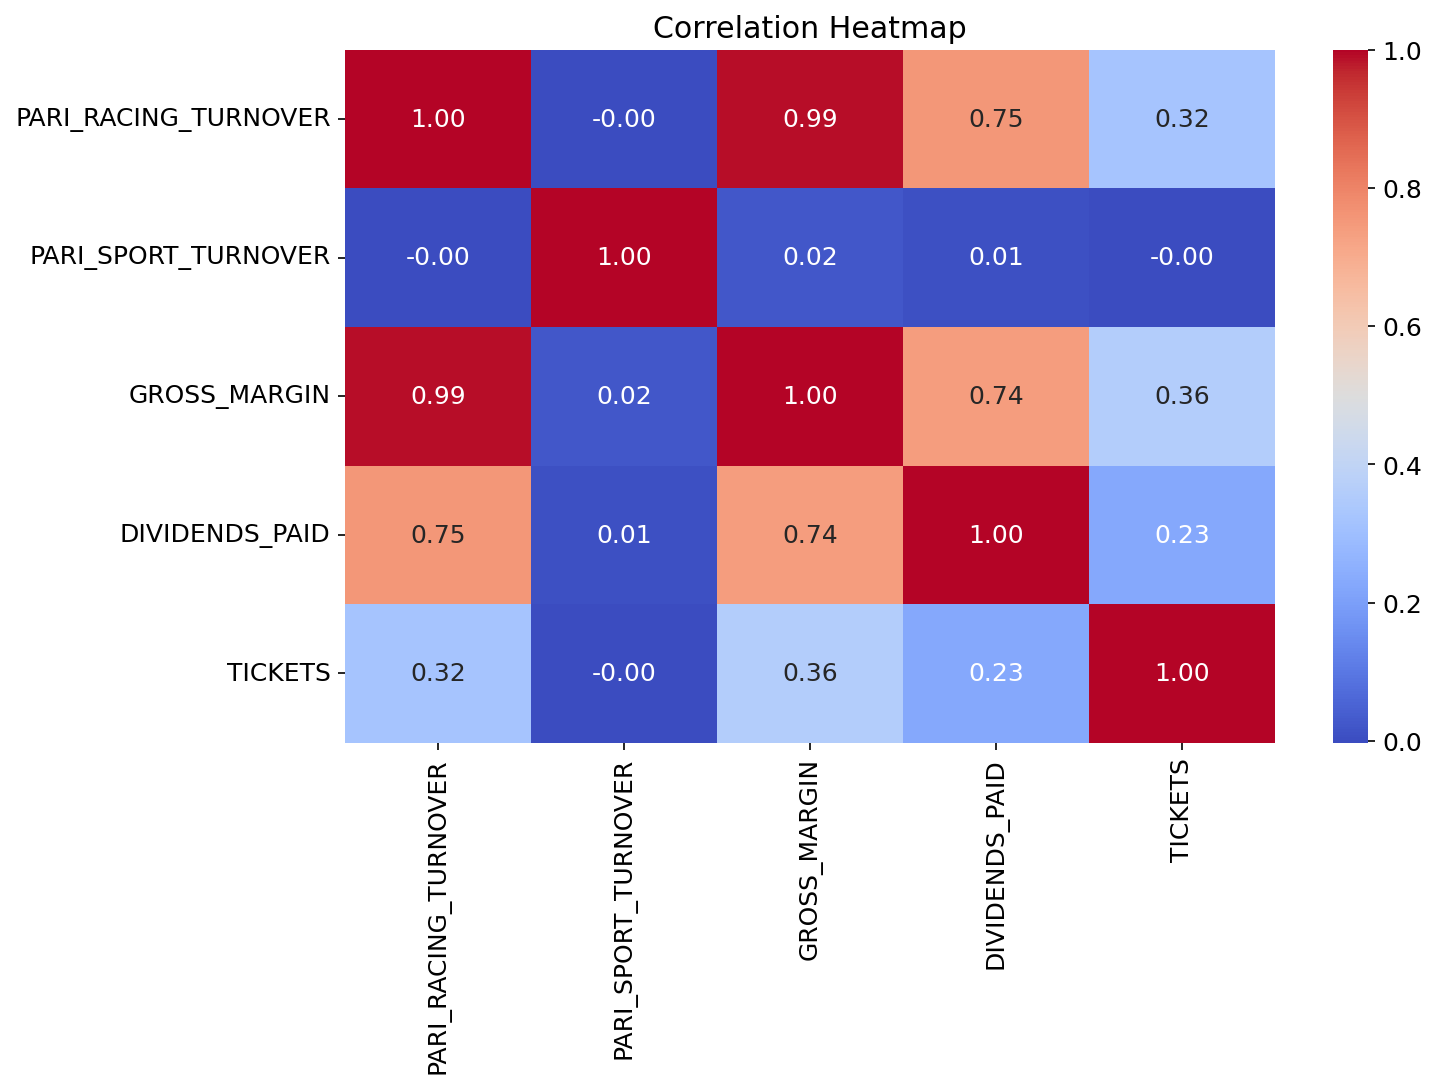

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[['PARI_RACING_TURNOVER', 'PARI_SPORT_TURNOVER', 'GROSS_MARGIN', 'DIVIDENDS_PAID', 'TICKETS']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
transaction_data['total'] = transaction_data['FOB_RACING_TURNOVER'] + transaction_data['FOB_SPORT_TURNOVER'] + transaction_data['PARI_RACING_TURNOVER'] + transaction_data['PARI_SPORT_TURNOVER']
transaction_data['different'] = transaction_data['TOTAL_TURNOVER'] - transaction_data['total']
transaction_data

,Unnamed: 0,DATE_DIM,DAY_OF_WEEK,MONTH_OF_YEAR,BET_ACCOUNT_NUM_HASH,FOB_RACING_TURNOVER,FOB_SPORT_TURNOVER,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS,YEAR,total,different
0,0,2021-01-01,Fri,1,13154,37.0,0.0,1081.0,0.0,1118.0,443.55,271.254275,288,2021,1118.0,0.0
1,1,2021-01-01,Fri,1,18379,40.0,0.0,0.0,0.0,40.0,0.00,40.000000,1,2021,40.0,0.0
2,2,2021-01-01,Fri,1,559232,0.0,0.0,12.0,0.0,12.0,9.50,2.041720,5,2021,12.0,0.0
3,3,2021-01-01,Fri,1,698904,0.0,0.0,1223.5,0.0,1223.5,267.91,245.117147,40,2021,1223.5,0.0
4,4,2021-01-01,Fri,1,762921,0.0,0.0,17.5,0.0,17.5,0.00,3.504075,5,2021,17.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12361146,12364096,2022-12-31,Sat,12,4293715592,28.0,0.0,53.0,0.0,81.0,103.10,38.770481,33,2022,81.0,0.0
12361147,12364097,2022-12-31,Sat,12,4294296954,450.0,0.0,0.0,0.0,450.0,475.00,-25.000000,9,2022,450.0,0.0
12361148,12364098,2022-12-31,Sat,12,4294378139,5.0,0.0,0.0,0.0,5.0,0.00,5.000000,1,2022,5.0,0.0
12361149,12364099,2022-12-31,Sat,12,4294561160,70.0,0.0,18.0,0.0,88.0,0.00,73.659467,12,2022,88.0,0.0


In [ ]:
# Drop Unnamed: 0
transaction_data = transaction_data.drop('Unnamed: 0', axis=1)
transaction_data = transaction_data.drop('total', axis=1)
transaction_data = transaction_data.drop('different', axis=1)

# 2. Convert original data to time series and EDA

## 2.1. Convert data to daily time series

In [6]:
grouped_data = transaction_data.groupby('DATE_DIM').agg({
    'FOB_RACING_TURNOVER': 'sum',
    'FOB_SPORT_TURNOVER': 'sum',
    'PARI_RACING_TURNOVER': 'sum',
    'PARI_SPORT_TURNOVER': 'sum',
    'TOTAL_TURNOVER': 'sum',
    'DIVIDENDS_PAID': 'sum',
    'GROSS_MARGIN': 'sum',
    'TICKETS': 'sum',
    'DAY_OF_WEEK': 'first',
    'MONTH_OF_YEAR': 'first',
    'YEAR': 'first'
})

In [ ]:
grouped_data

,FOB_RACING_TURNOVER,FOB_SPORT_TURNOVER,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS,DAY_OF_WEEK,MONTH_OF_YEAR,YEAR
DATE_DIM,,,,,,,,,,,
2021-01-01,1740318.55,160299.45,1934935.51,0.0,3835553.51,3114653.42,6.122205e+05,488231,Fri,1,2021
2021-01-02,3329675.95,257613.55,2578252.53,2.0,6165544.03,4950145.30,1.108986e+06,698207,Sat,1,2021
2021-01-03,930583.79,331455.71,935813.69,0.0,2197853.19,1826918.53,3.290954e+05,280680,Sun,1,2021
2021-01-04,586806.57,321699.93,614867.17,183.5,1523557.17,1287351.59,1.998129e+05,194823,Mon,1,2021
2021-01-05,602362.79,224912.71,653355.82,147.5,1480778.82,1213737.41,2.517490e+05,201668,Tue,1,2021
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,1144583.00,311997.79,957148.91,0.0,2413729.70,1926794.75,3.965817e+05,311197,Tue,12,2022
2022-12-28,1741932.50,259758.31,1378002.76,0.0,3379693.57,2825398.22,5.065596e+05,428845,Wed,12,2022
2022-12-29,1491746.50,284268.77,1086322.72,385.0,2862722.99,2417415.20,3.732281e+05,361745,Thu,12,2022


## 2.2. EDA Time Series

In [ ]:
grouped_data.index.freq = 'MS'

In [ ]:
grouped_data['TOTAL_TURNOVER'].describe()

count    7.300000e+02
mean     3.006540e+06
std      1.541438e+06
min      9.301586e+04
25%      1.967971e+06
50%      2.677905e+06
75%      3.078644e+06
max      1.278913e+07
Name: TOTAL_TURNOVER, dtype: float64

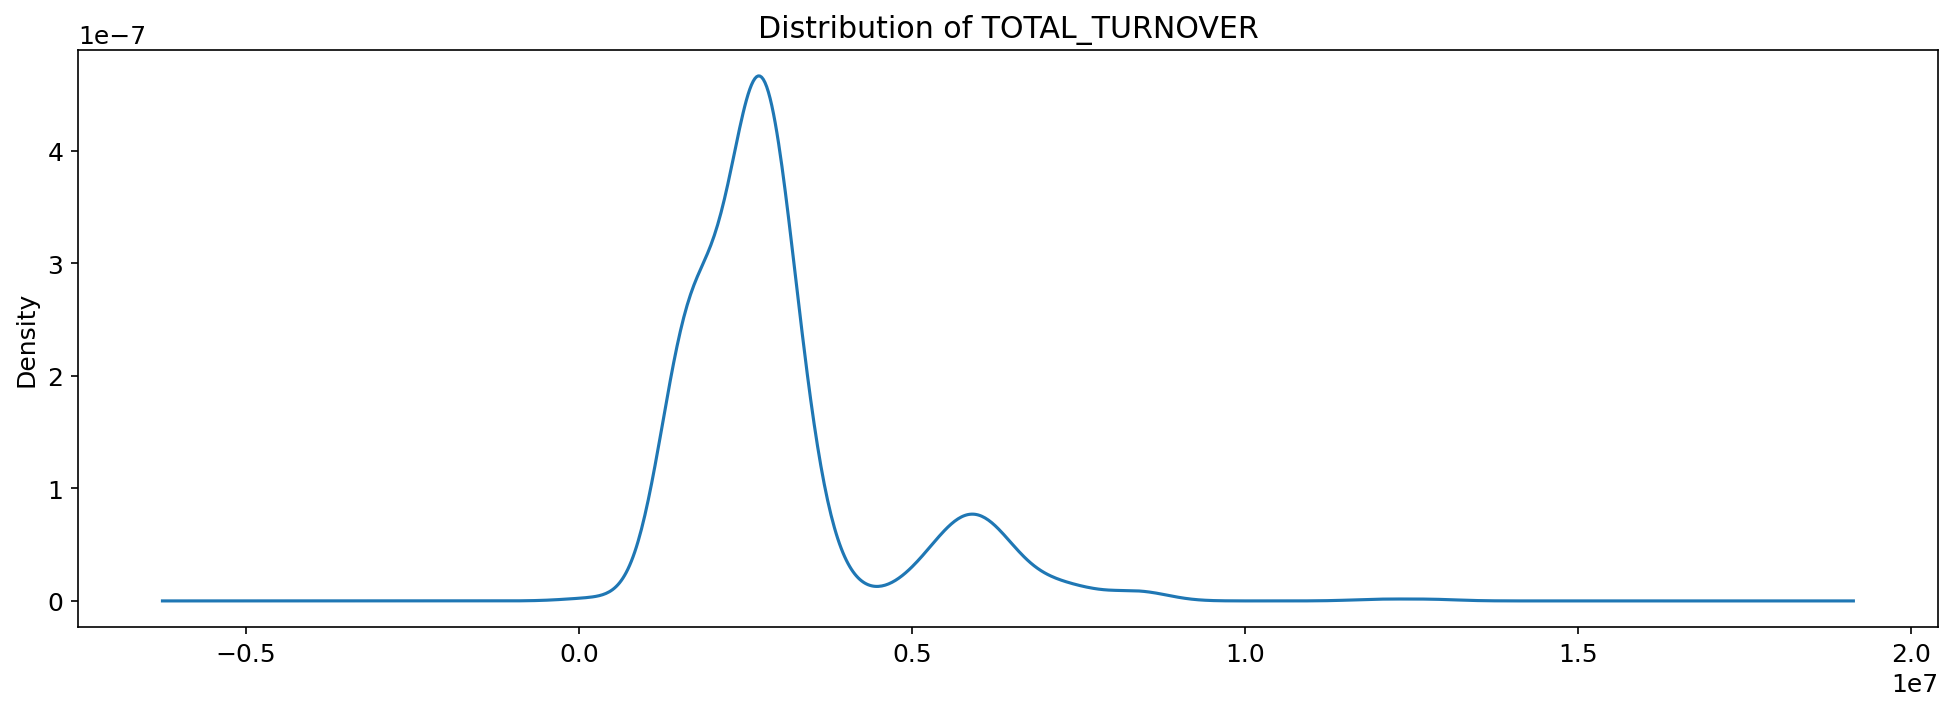

In [ ]:
# Distribution of the dataset
grouped_data['TOTAL_TURNOVER'].plot(kind='kde', title='Distribution of TOTAL_TURNOVER')
plt.show()

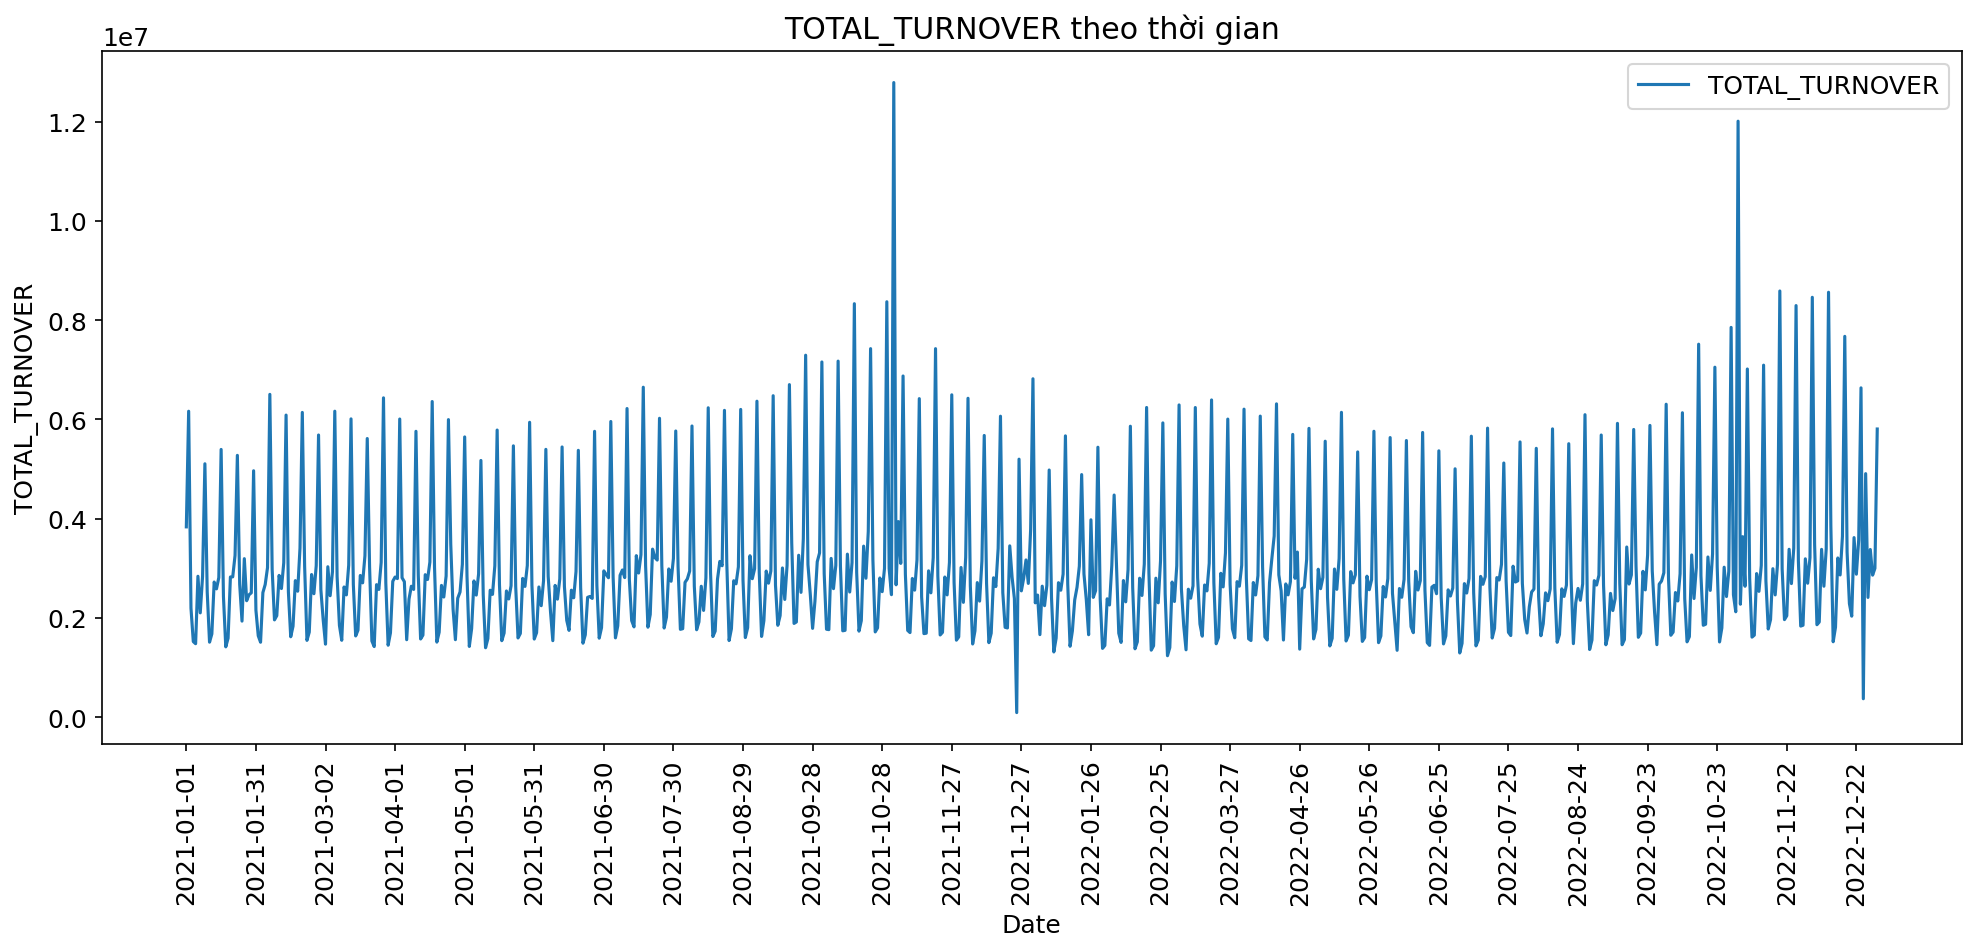

In [ ]:
# Visualize TOTAL_TURNOVER
plt.figure(figsize=(16, 6))
plt.plot(grouped_data['TOTAL_TURNOVER'], label='TOTAL_TURNOVER')
plt.title('TOTAL_TURNOVER theo thời gian')
plt.xlabel('Date')
plt.ylabel('TOTAL_TURNOVER')
plt.legend()

num_ticks = 24
step = len(grouped_data) // num_ticks

# Set ticks on the x-axis
plt.xticks(range(0, len(grouped_data), step), grouped_data.index[::step], rotation=90)

plt.show()

In [ ]:
# Calculate quartiles
quartiles = grouped_data['TOTAL_TURNOVER'].quantile([0.25, 0.5, 0.75])

# Print quartiles
print("Quartiles:")
print(quartiles)

# Calculate IQR
iqr = quartiles[0.75] - quartiles[0.25]

# Print IQR
print("\nInterquartile Range (IQR):")
print(iqr)

Quartiles:
0.25    1.967971e+06
0.50    2.677905e+06
0.75    3.078644e+06
Name: TOTAL_TURNOVER, dtype: float64

Interquartile Range (IQR):
1110673.2275000003


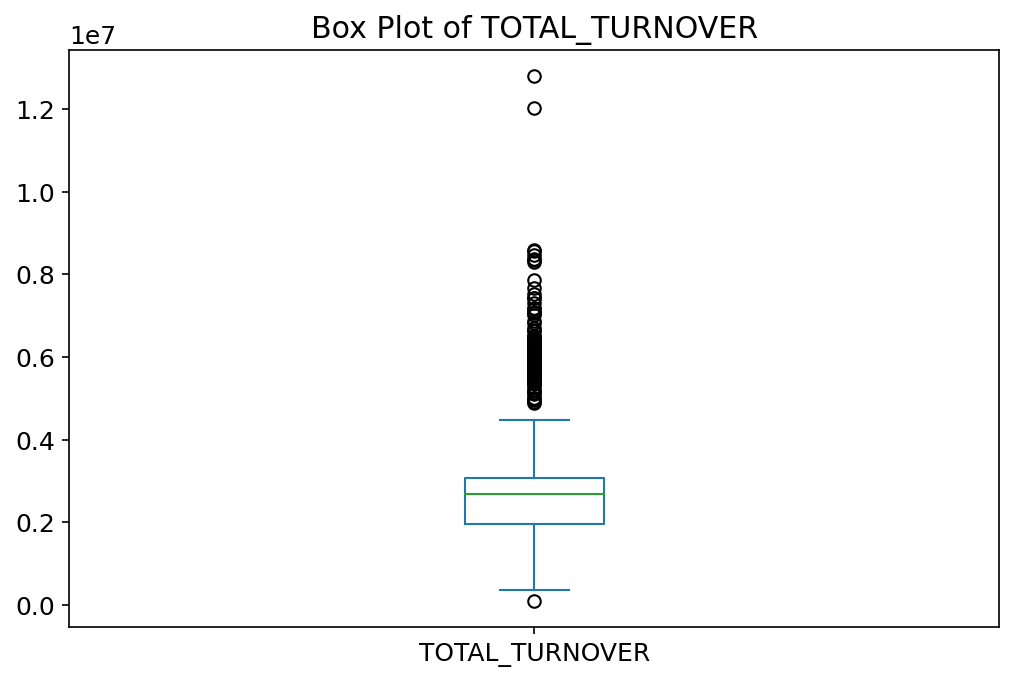

In [ ]:
grouped_data['TOTAL_TURNOVER'].plot(kind='box', title='Box Plot of TOTAL_TURNOVER')
plt.show()

## 2.3. Time series decomposition

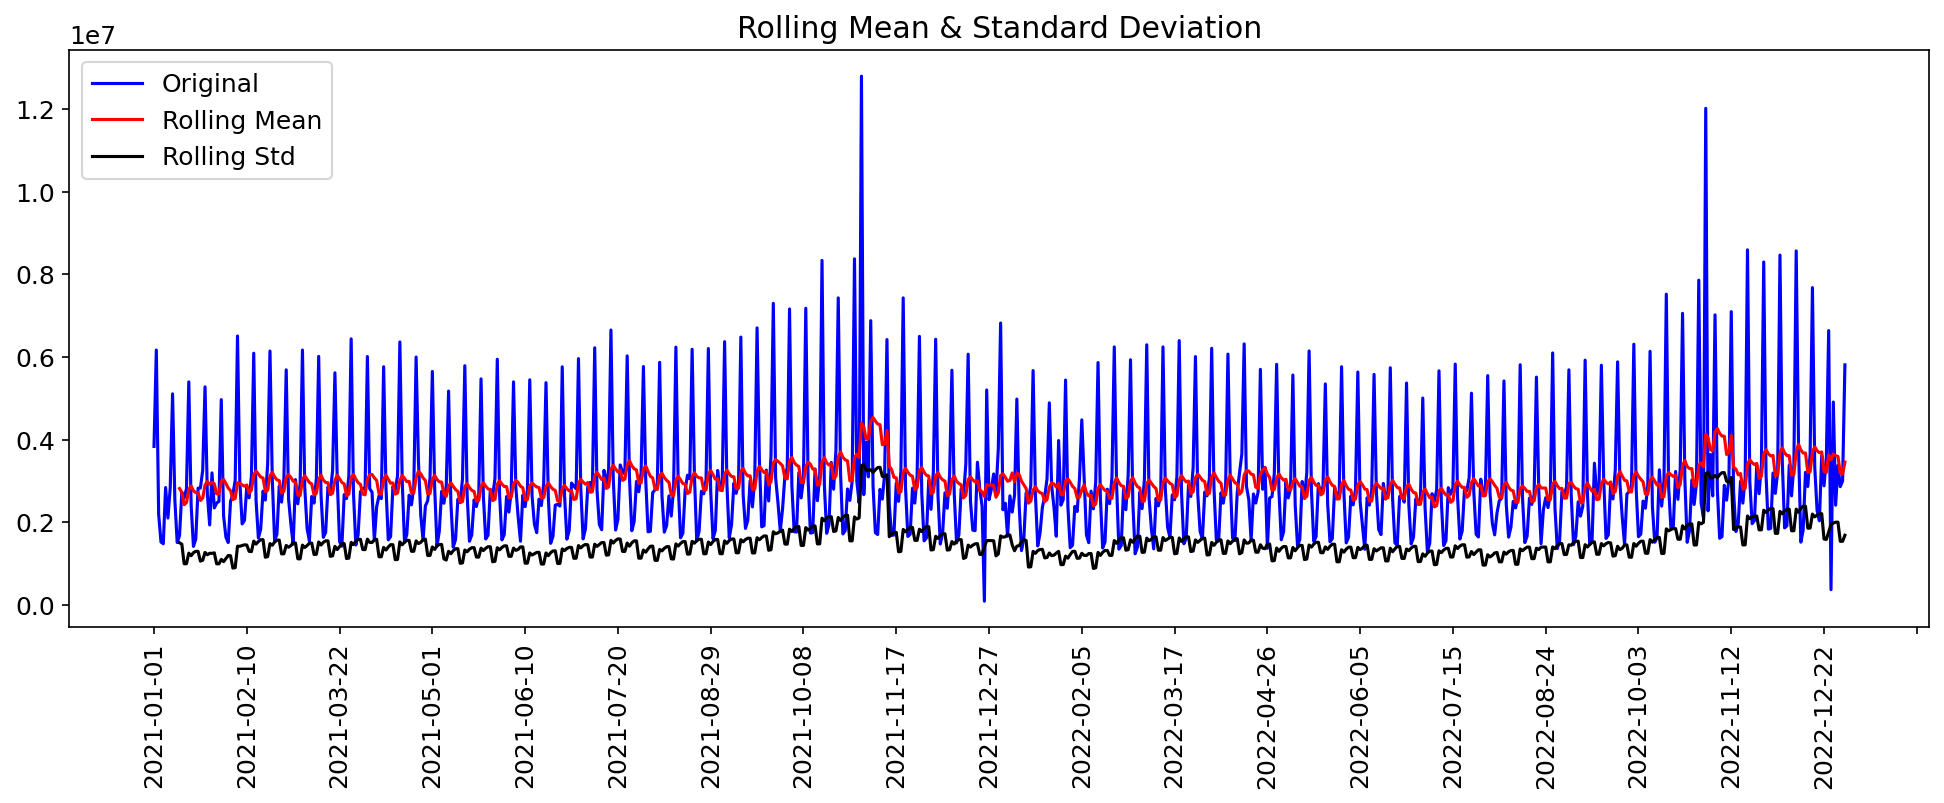

In [ ]:
rolmean = grouped_data['TOTAL_TURNOVER'].rolling(window=12).mean()
rolstd = grouped_data['TOTAL_TURNOVER'].rolling(window=12).std()

plt.plot(grouped_data.index, grouped_data['TOTAL_TURNOVER'], color='blue', label='Original')
plt.plot(rolmean.index, rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd.index, rolstd, color='black', label='Rolling Std')

plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(24))

plt.legend()
plt.title('Rolling Mean & Standard Deviation')
plt.show()

Test the stationarity of the time series

In [ ]:
print('Augmented Dickey-Fuller Test:')
indices = ['Test Statistic', 'p-value', 'No. Lags Used', 'Number of Observations Used']
test = adfuller(grouped_data['TOTAL_TURNOVER'], autolag='AIC')
result = pd.Series(data=test[0:4], index=indices)
for key, value in test[4].items():
    result[f'Critical Value ({key})'] = value
print(result)
print('---------')
print('KPSS Test:')
indices = ['Test Statistic', 'p-value', 'No. Lags Used']
test = kpss(grouped_data['TOTAL_TURNOVER'])
result = pd.Series(data=test[0:3], index=indices)
for key, value in test[3].items():
    result[f'Critical Value ({key})'] = value
print(result)

Augmented Dickey-Fuller Test:
Test Statistic                  -2.758498
p-value                          0.064451
No. Lags Used                   20.000000
Number of Observations Used    709.000000
Critical Value (1%)             -3.439607
Critical Value (5%)             -2.865625
Critical Value (10%)            -2.568945
dtype: float64
---------
KPSS Test:
Test Statistic             0.138584
p-value                    0.100000
No. Lags Used            174.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


=> The time series is stationary

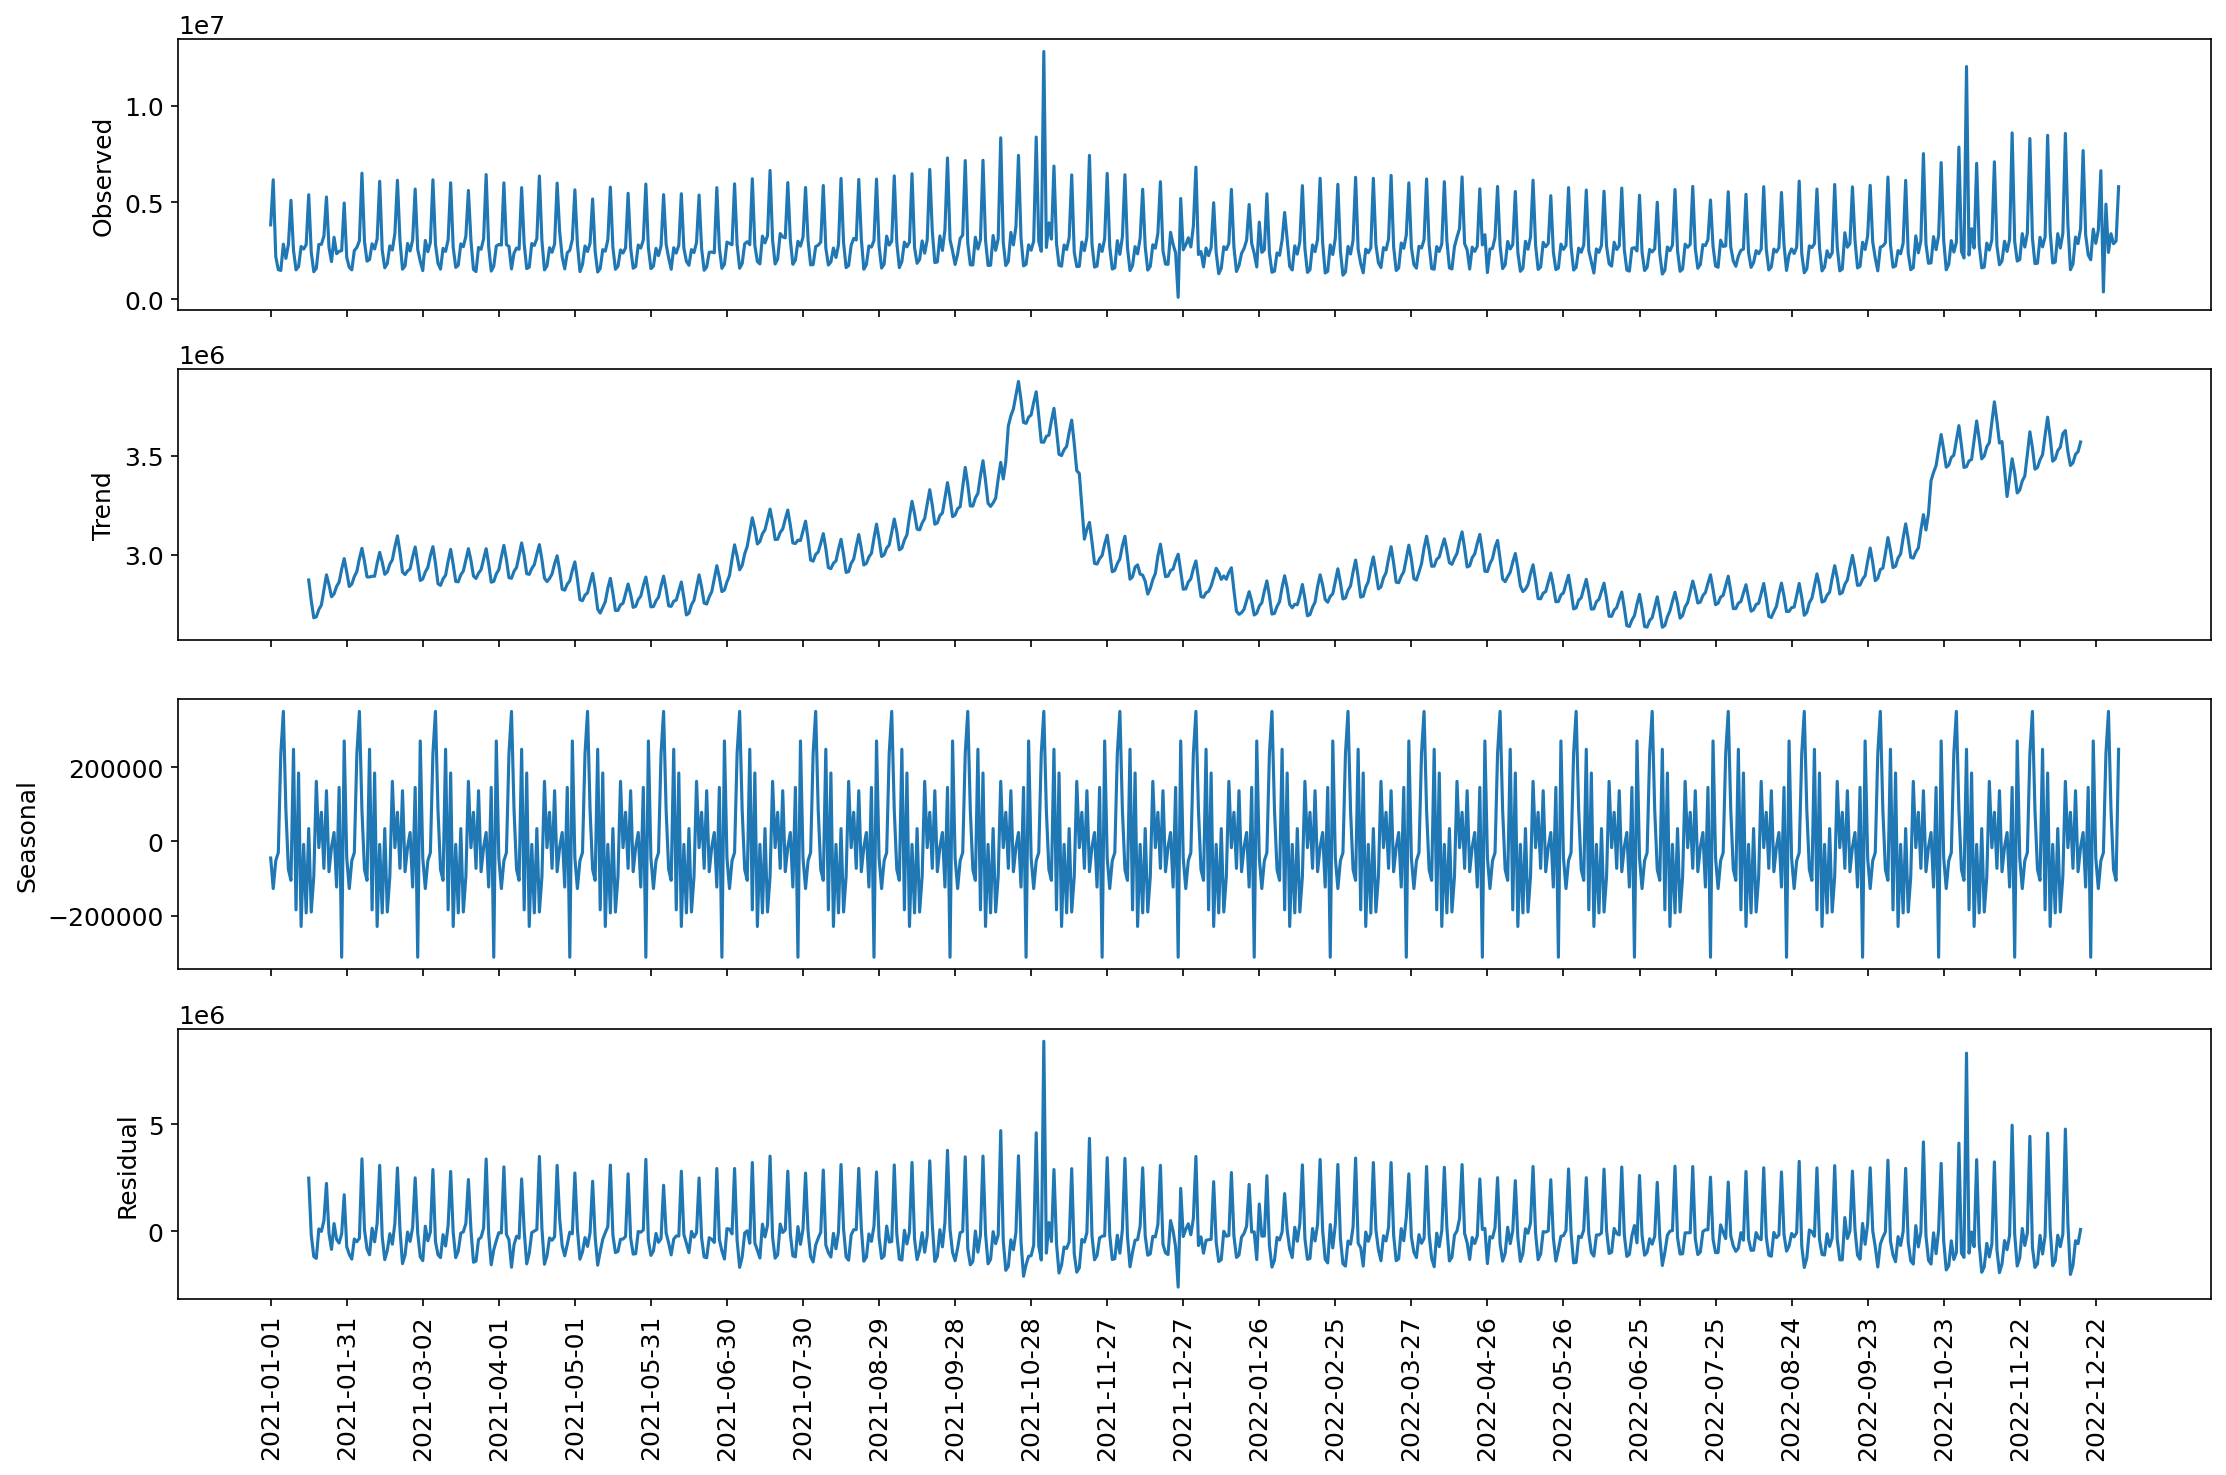

In [ ]:
decompose_result = seasonal_decompose(grouped_data['TOTAL_TURNOVER'], model='add', period=30)

fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
axes[0].plot(decompose_result.observed)
axes[0].set_ylabel('Observed')
axes[1].plot(decompose_result.trend)
axes[1].set_ylabel('Trend')
axes[2].plot(decompose_result.seasonal)
axes[2].set_ylabel('Seasonal')
axes[3].plot(decompose_result.resid)
axes[3].set_ylabel('Residual')

num_ticks = 24
x_ticks_indices = range(0, len(grouped_data), len(grouped_data) // num_ticks)
x_ticks_labels = grouped_data.index[x_ticks_indices]
axes[3].set_xticks(x_ticks_indices)
axes[3].set_xticklabels(x_ticks_labels, rotation=90)
plt.tight_layout()
plt.show()

# 3. Build model

## 3.1. Train, test data

In [27]:
train_data, test_data = grouped_data['TOTAL_TURNOVER'][:int(len(grouped_data['TOTAL_TURNOVER'])*0.9)], grouped_data['TOTAL_TURNOVER'][int(len(grouped_data['TOTAL_TURNOVER'])*0.9):]

In [ ]:
train_data

DATE_DIM
2021-01-01    3835553.51
2021-01-02    6165544.03
2021-01-03    2197853.19
2021-01-04    1523557.17
2021-01-05    1480778.82
                 ...    
2022-10-15    7516674.26
2022-10-16    2848717.81
2022-10-17    1852783.58
2022-10-18    1873351.35
2022-10-19    3228836.24
Name: TOTAL_TURNOVER, Length: 657, dtype: float64

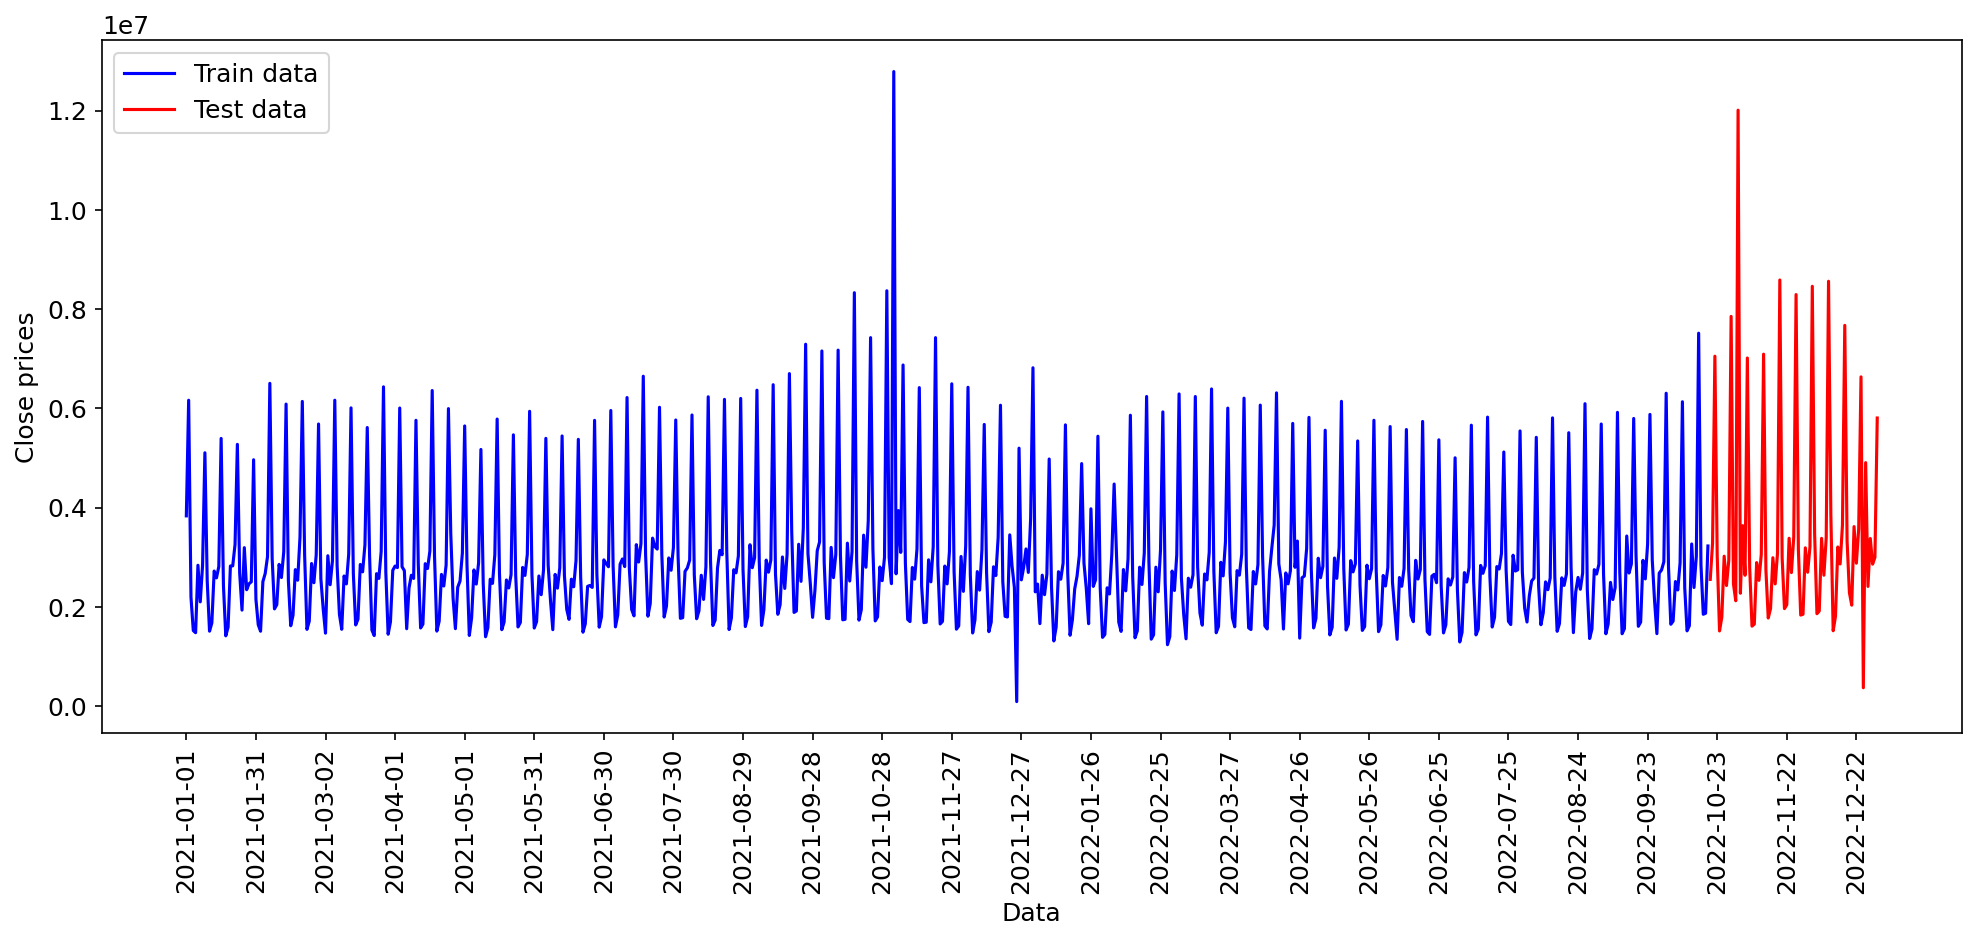

In [ ]:
# Plot train and test data
plt.figure(figsize=(16, 6))
plt.plot(train_data, 'blue', label='Train data')
plt.plot(test_data, 'red', label='Test data')

num_ticks = 24
x_ticks_indices = range(0, len(grouped_data['TOTAL_TURNOVER']), len(grouped_data['TOTAL_TURNOVER']) // num_ticks)
x_ticks_labels = grouped_data['TOTAL_TURNOVER'].index[x_ticks_indices]
plt.xticks(x_ticks_labels, rotation=90)
plt.xlabel('Data')
plt.ylabel('Close prices')
plt.legend()
plt.show()

## 3.2. ARIMA

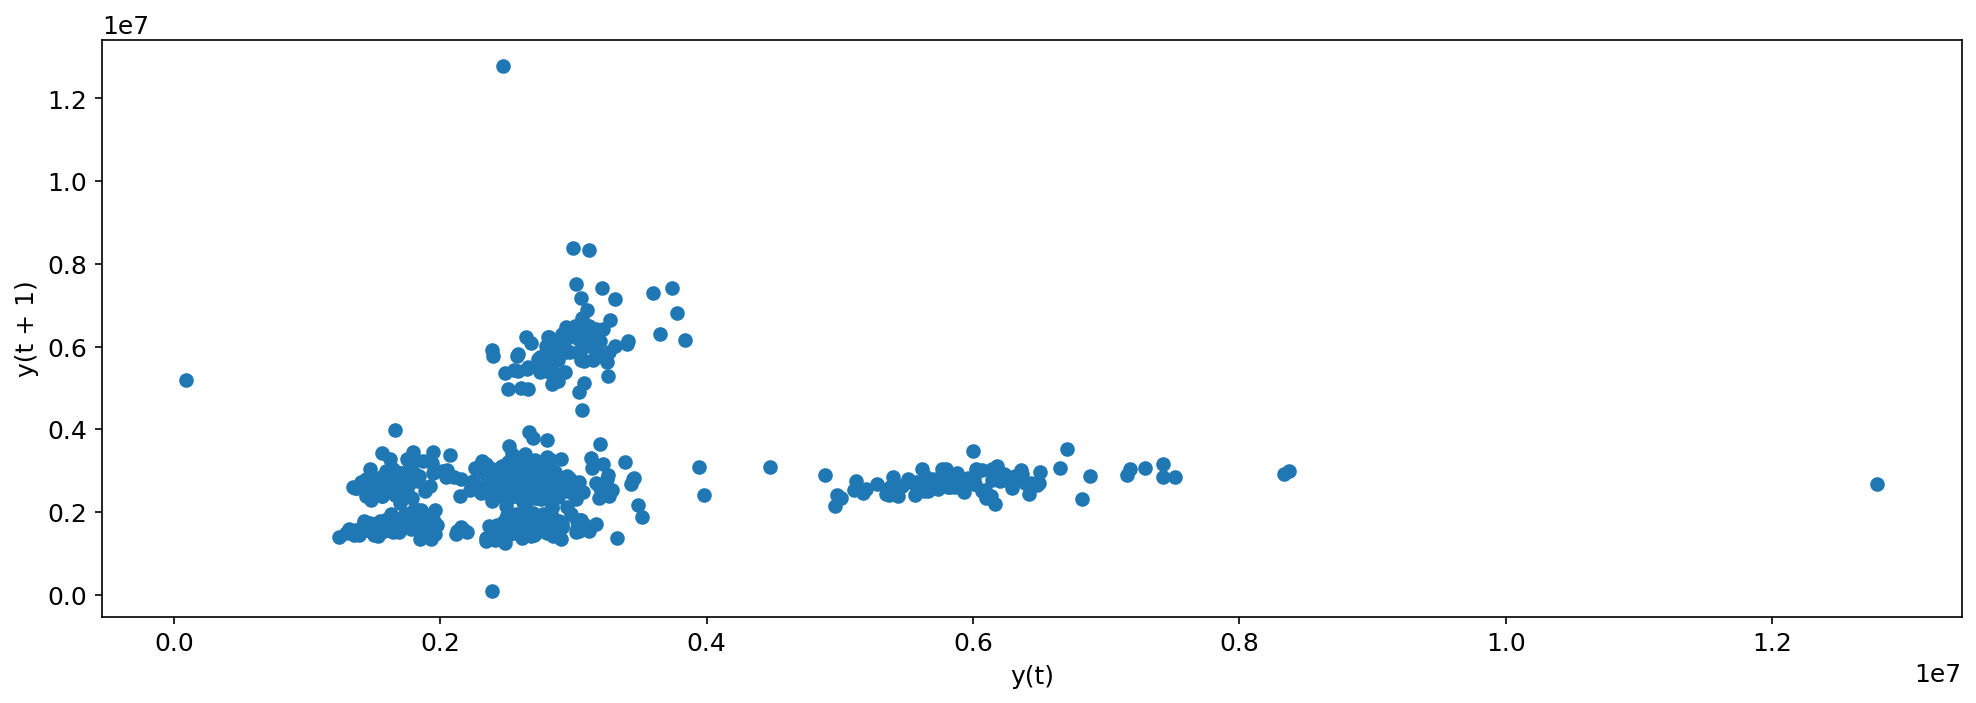

In [ ]:
# autocorrelation test
pd.plotting.lag_plot(train_data)
plt.show()

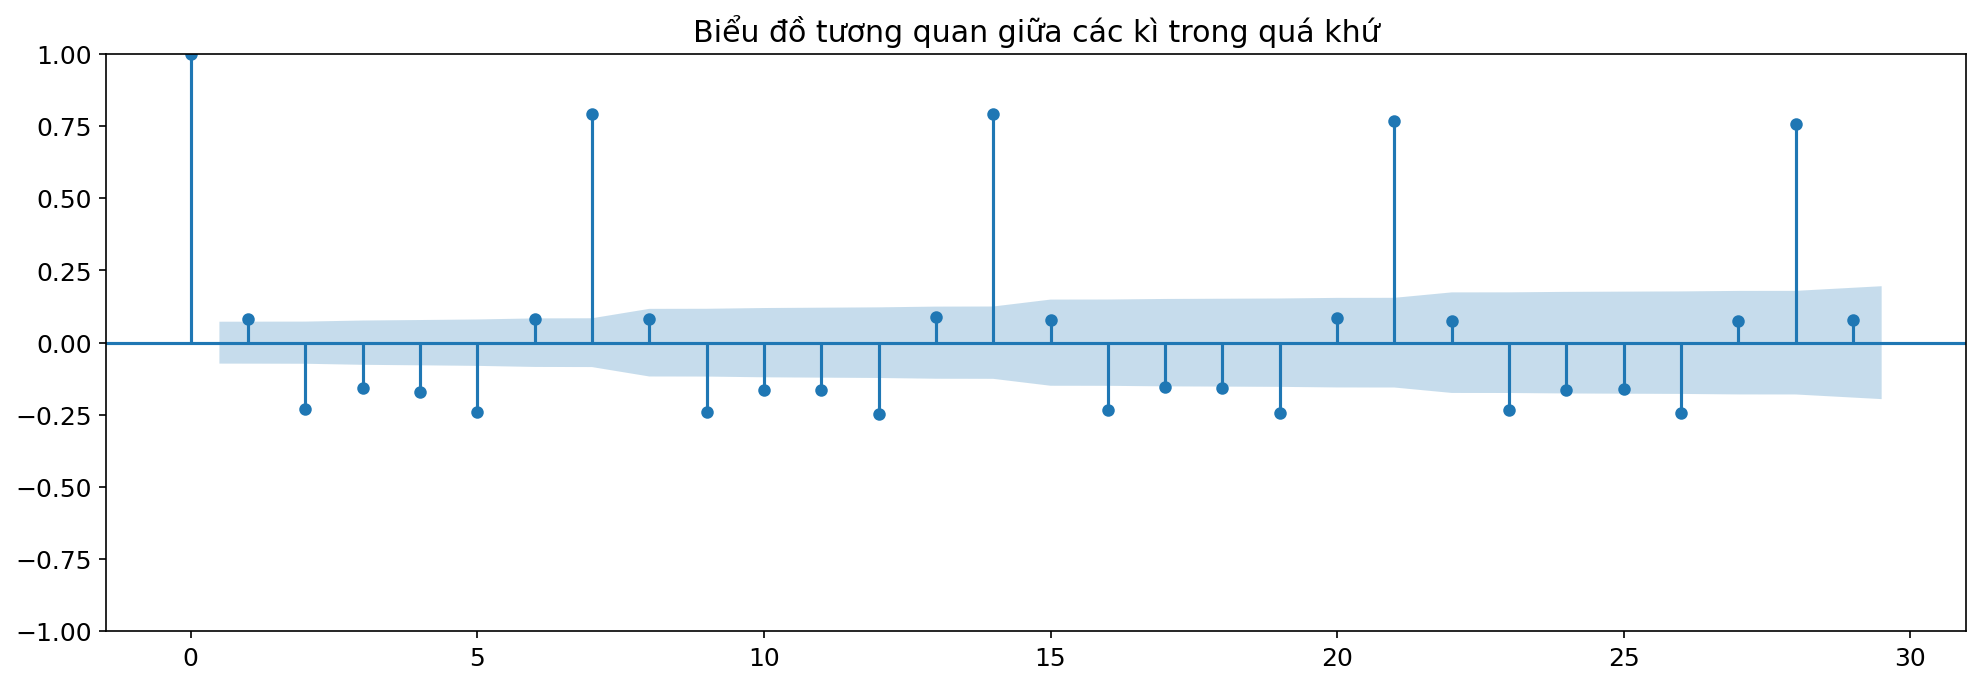

In [ ]:
plot_acf(grouped_data['TOTAL_TURNOVER'])
plt.title("Biểu đồ tương quan giữa các kì trong quá khứ")
plt.show()

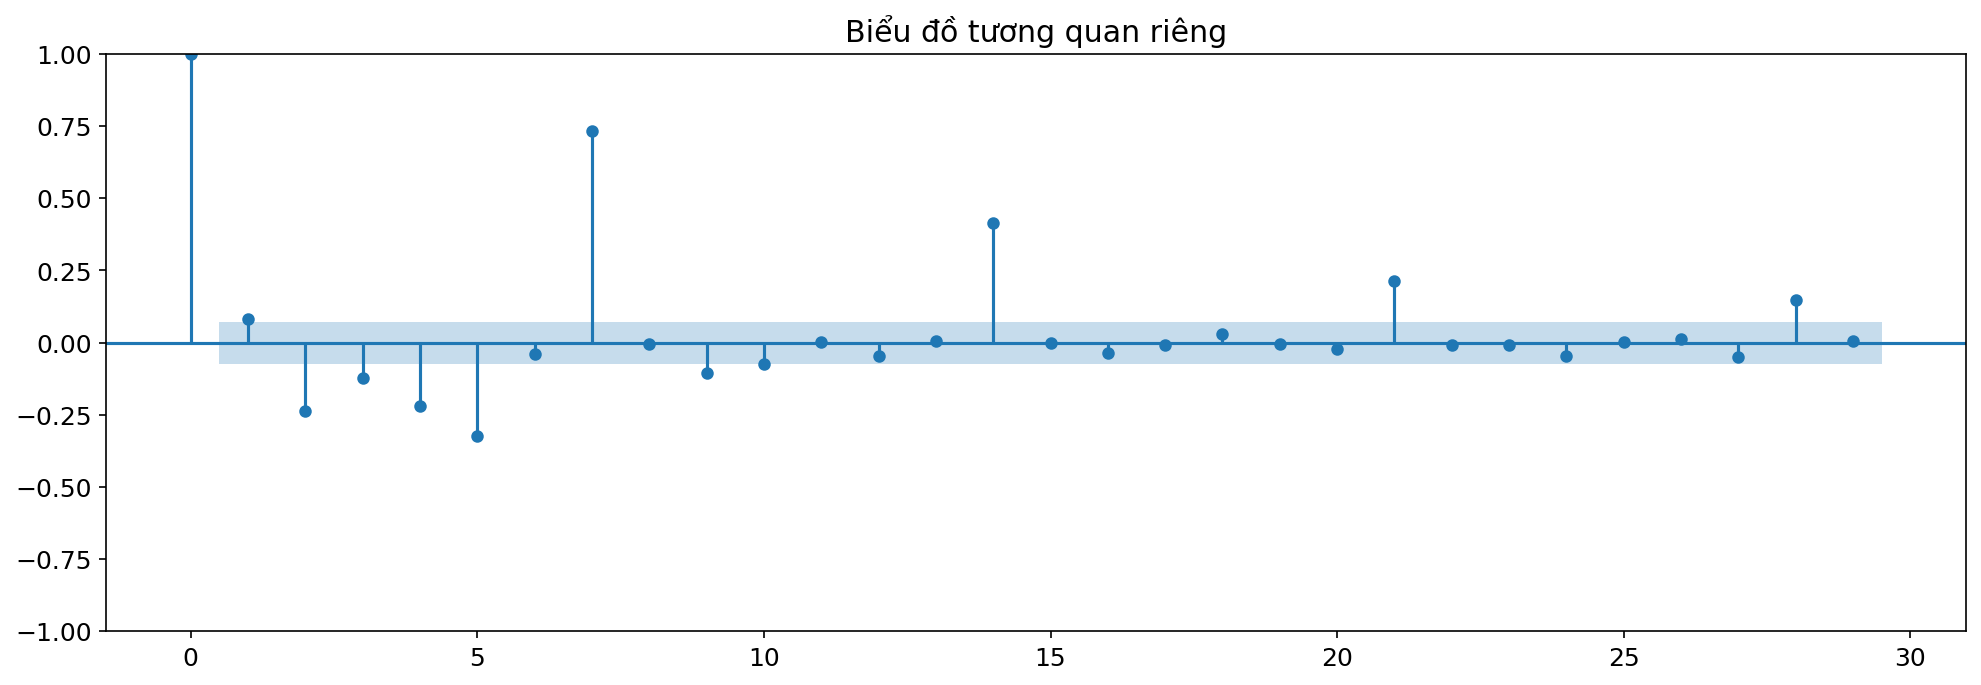

In [ ]:
plot_pacf(grouped_data['TOTAL_TURNOVER'])
plt.title("Biểu đồ tương quan riêng")
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=22828.322, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23288.747, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23208.380, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22903.055, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23286.749, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=22825.452, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=22868.337, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22894.288, Time=0.27 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=22838.683, Time=0.69 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=22855.216, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=22853.855, Time=0.38 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.50 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=22817.941, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0]        

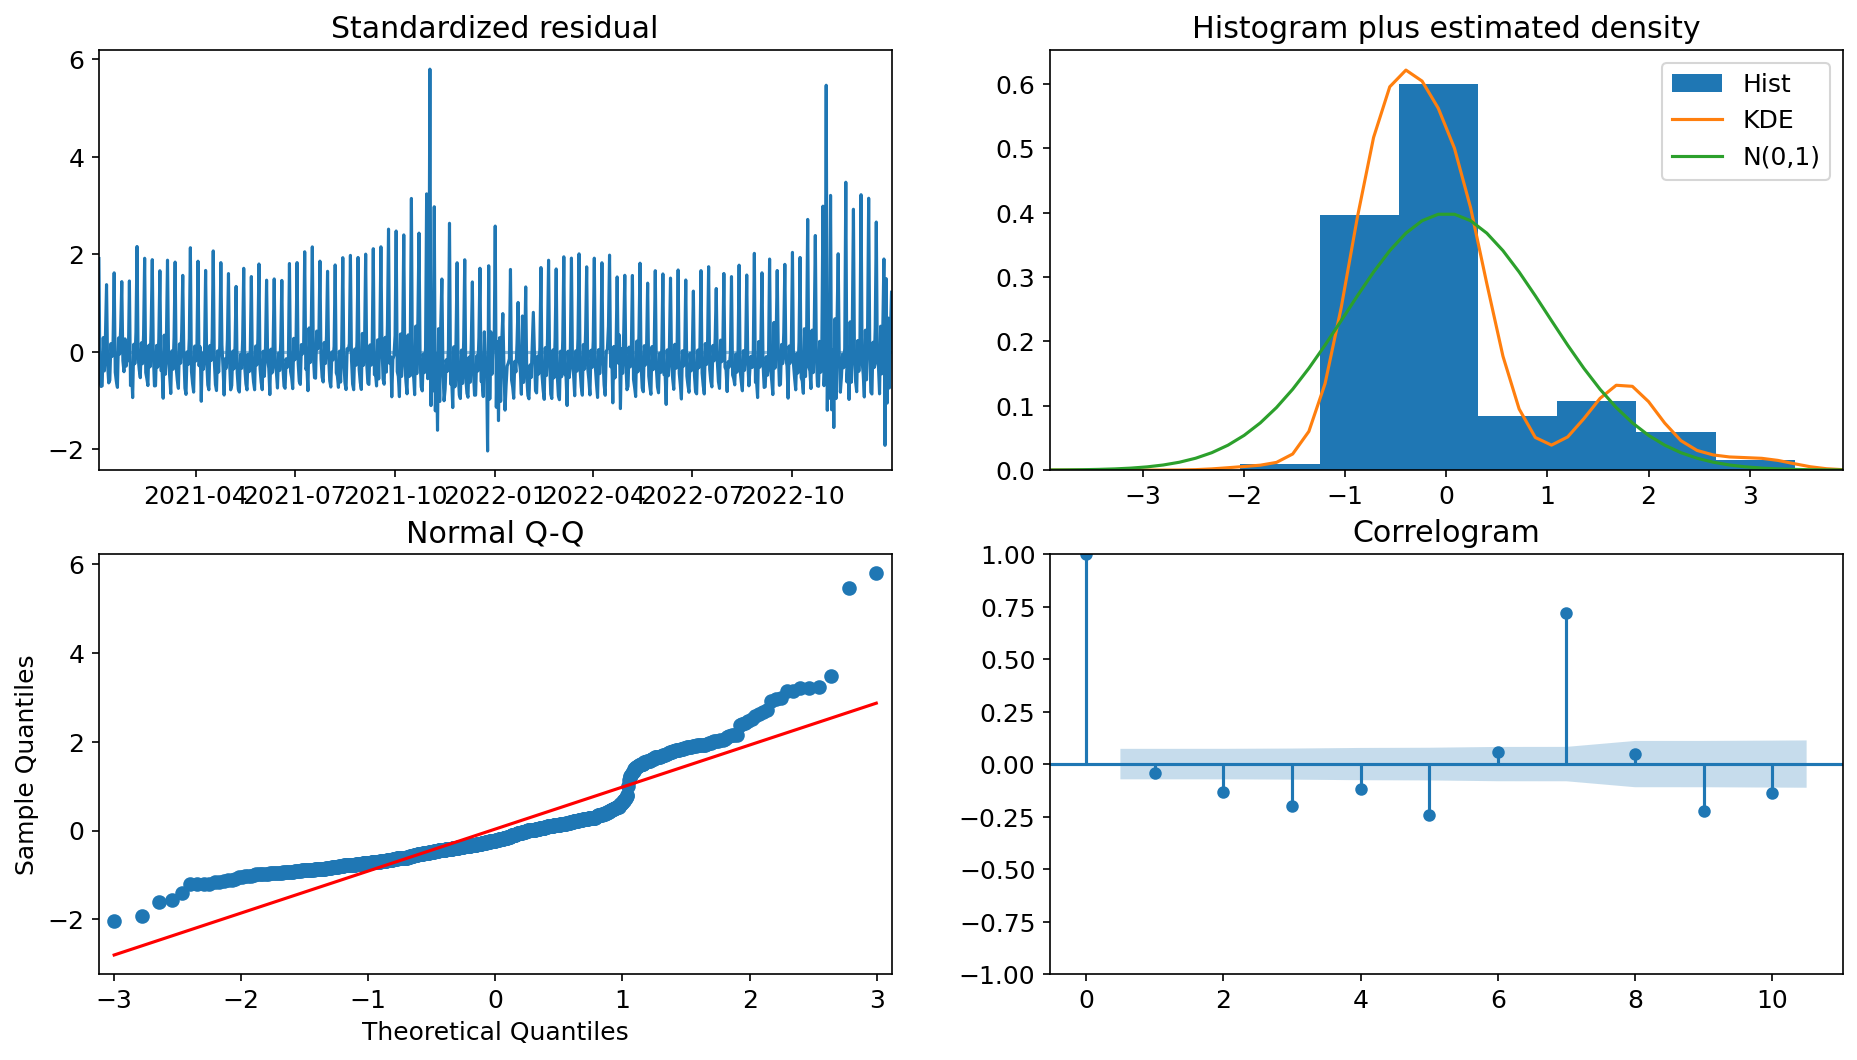

In [ ]:
# P, D, Q parameters for ARIMA model - pmd arima
stepwise = auto_arima(grouped_data['TOTAL_TURNOVER'], trace=True, suppress_warnings=True)
print(stepwise.summary())
stepwise.plot_diagnostics(figsize=(15, 8))
plt.show()

In [28]:
# ARIMA model
modelARIMA = ARIMA(train_data, order=(5, 1, 5))
arima_result = modelARIMA.fit()
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:         TOTAL_TURNOVER   No. Observations:                  657
Model:                 ARIMA(5, 1, 5)   Log Likelihood              -10011.627
Date:                Sun, 31 Mar 2024   AIC                          20045.253
Time:                        11:39:50   BIC                          20094.601
Sample:                    01-01-2021   HQIC                         20064.386
                         - 10-19-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2499      0.077      3.241      0.001       0.099       0.401
ar.L2         -0.9996      0.065    -15.342      0.000      -1.127      -0.872
ar.L3          0.0096      0.107      0.089      0.9

In [29]:
# Dự đoán (predict)
predictionsARIMA = arima_result.get_forecast(len(test_data))
predictions_values = predictionsARIMA.predicted_mean
predictions_values.index=test_data.index

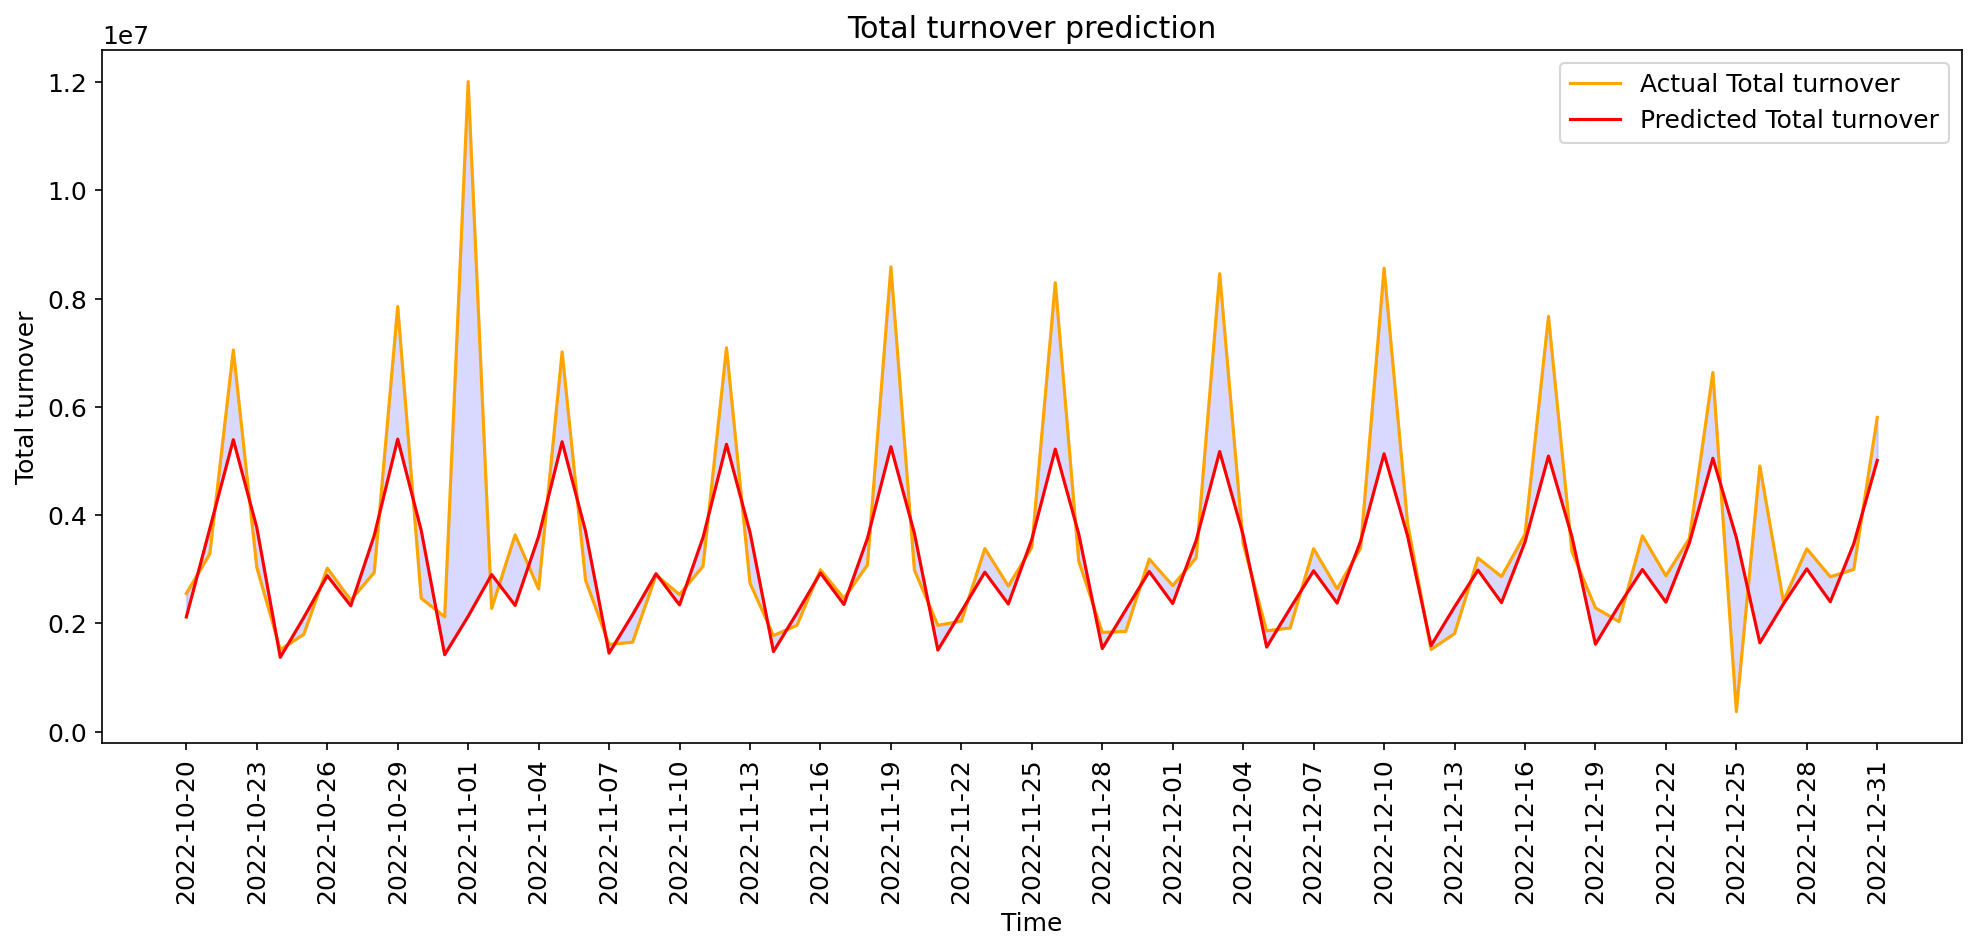

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(test_data.index, test_data, color='orange', label='Actual Total turnover')
plt.plot(predictions_values.index, predictions_values, color='red', label='Predicted Total turnover')
plt.fill_between(predictions_values.index, predictions_values, test_data, color='blue', alpha=0.15)

num_ticks = 24
x_ticks_indices = range(0, len(test_data), len(test_data) // num_ticks)
x_ticks_labels = test_data.index[x_ticks_indices]
plt.xticks(x_ticks_labels, rotation=90)
plt.title('Total turnover prediction')
plt.xlabel('Time')
plt.ylabel('Total turnover')
plt.legend()
plt.show()

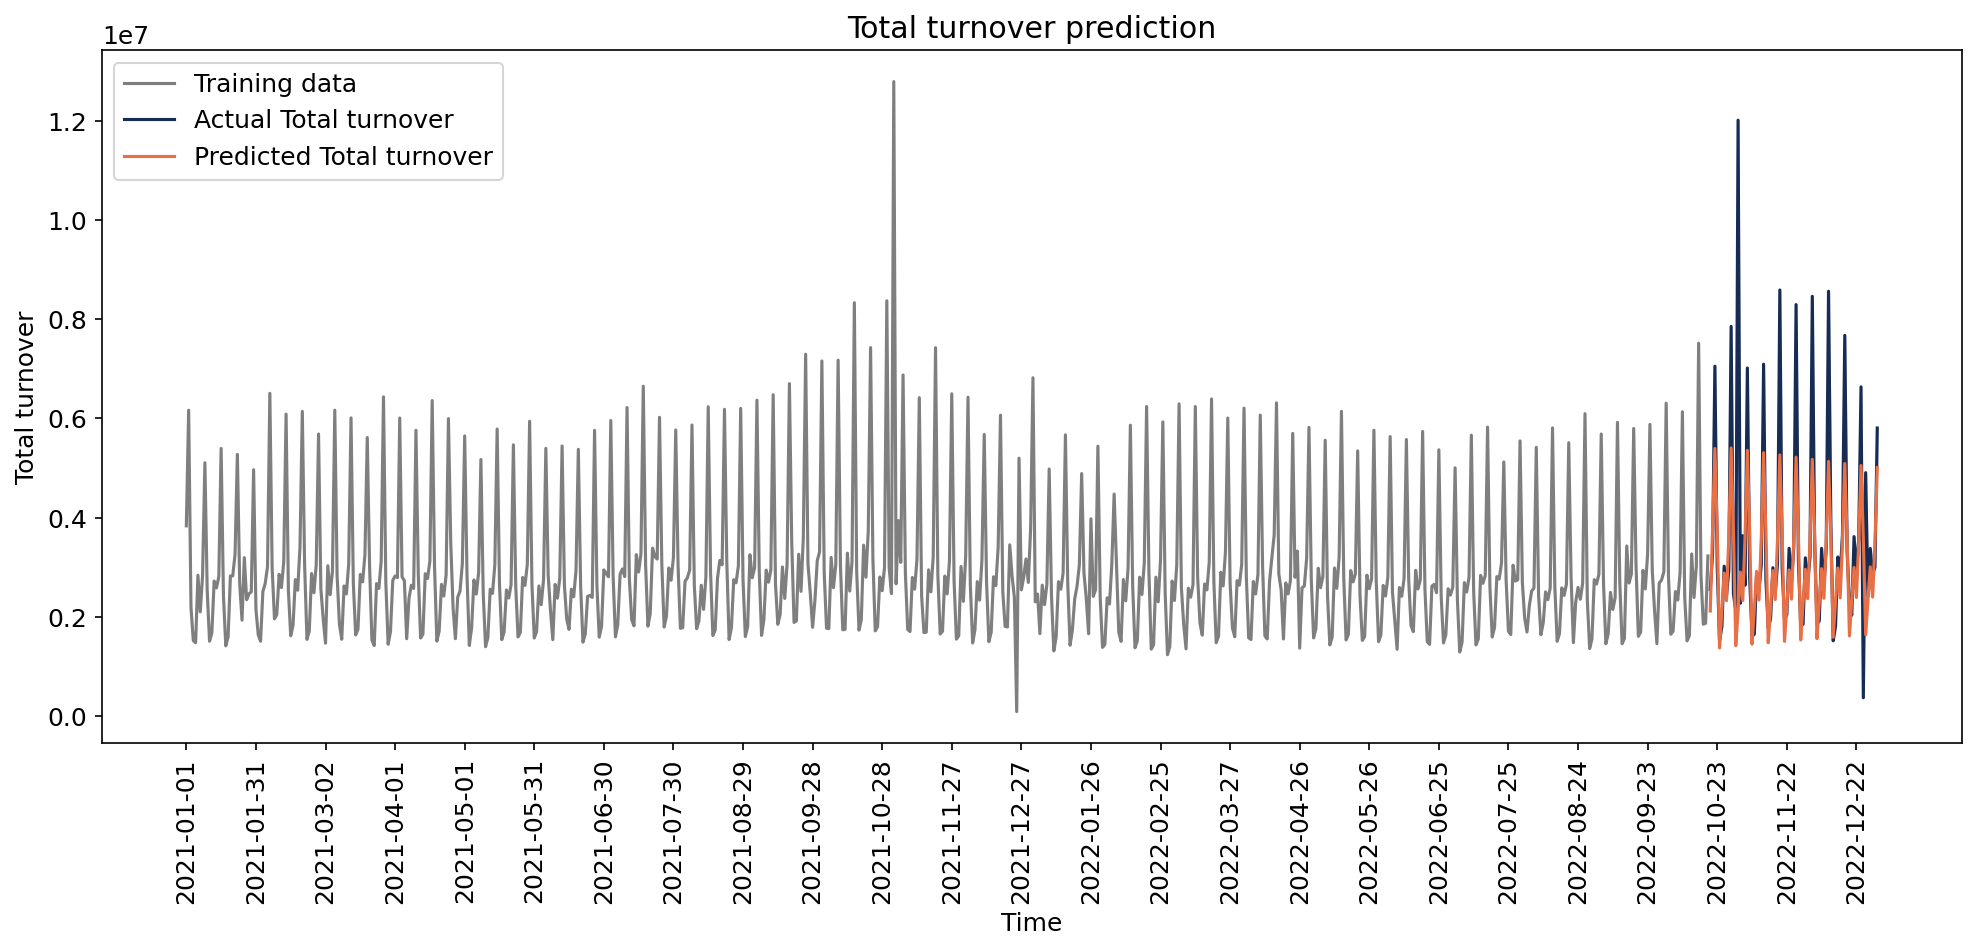

In [31]:
plt.figure(figsize=(16, 6))
plt.plot(train_data.index, train_data, color='#7f7f7f',label='Training data')
plt.plot(test_data.index, test_data, color='#162C54', label='Actual Total turnover')
plt.plot(predictions_values.index, predictions_values, color='#E96F45', label='Predicted Total turnover')
plt.fill_between(predictions_values.index, predictions_values, test_data, color='blue', alpha=0.15)

num_ticks = 24
x_ticks_indices = range(0, len(train_data) + len(test_data), (len(train_data) + len(test_data)) // num_ticks)
x_ticks_labels = train_data.index.union(test_data.index)[x_ticks_indices]
plt.xticks(x_ticks_labels, rotation=90)

plt.title('Total turnover prediction')
plt.xlabel('Time')
plt.ylabel('Total turnover')
plt.legend()
plt.show()

In [ ]:
results = []

In [ ]:
# Validate model
mse = ((predictions_values - test_data)**2).mean()
rmse = np.sqrt(mse)
print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAPE: ', np.mean(np.abs(predictions_values - test_data)/np.abs(test_data))*100)
print('MAE: ', np.mean(np.abs(predictions_values - test_data)))

results.append(['ARIMA', np.mean(np.abs(predictions_values - test_data)), mse, rmse, np.mean(np.abs(predictions_values - test_data)/np.abs(test_data))*100])

MSE:  2742512947384.2866
RMSE:  1656053.425280805
MAPE:  30.910974335102342
MAE:  899947.0362078534


## 3.3. RNN

In [10]:
# Feature selection
selected_features = ['TOTAL_TURNOVER']

In [11]:
# Extract selected features
data = grouped_data[selected_features].values

In [12]:
# # Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [13]:
# Define sequence length (number of time steps to look back)
sequence_length = 10
sequences = []
targets = []
for i in range(len(scaled_data) - sequence_length):
    sequences.append(scaled_data[i:i + sequence_length])
    targets.append(scaled_data[i + sequence_length, -1])
# Convert sequences and targets to numpy arrays
sequences = np.array(sequences)
targets = np.array(targets)

In [14]:
# Split data into train and test sets
X_train, X_test = sequences[:int(len(sequences)*0.9)], sequences[int(len(sequences)*0.9):]
y_train, y_test = targets[:int(len(targets)*0.9)], targets[int(len(targets)*0.9):]

In [15]:
def calculate_metrics(predictions, actual_values):
    mae = np.mean(np.abs(predictions - actual_values))
    mse = np.mean((predictions - actual_values)**2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100
    return mae, mse, rmse, mape

In [ ]:
for i in range(5):
    results_lstm=[]
    results_gru=[]
    model_lstm = Sequential()
    model_lstm.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, len(selected_features))))
    model_lstm.add(LSTM(50, return_sequences=False))
    model_lstm.add(Dense(1))
    model_lstm.compile(optimizer='adam', loss='mean_squared_error')

    model_gru = Sequential()
    model_gru.add(GRU(50, return_sequences=True, input_shape=(sequence_length, len(selected_features))))
    model_gru.add(GRU(50, return_sequences=False))
    model_gru.add(Dense(1))
    model_gru.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history_lstm = model_lstm.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=0)
    history_gru = model_gru.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=0)

    predictions_lstm = model_lstm.predict(X_test)
    predictions_lstm = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], predictions_lstm), axis=1))[:, -1]
    predictions_gru = model_gru.predict(X_test)
    predictions_gru = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], predictions_gru), axis=1))[:, -1]

    actual_values = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]

    mse_lstm = np.mean((predictions_lstm - actual_values)**2)
    mse_gru = np.mean((predictions_gru - actual_values)**2)

    if i == 0 or mse_lstm < best_mse_lstm:
        best_mse_lstm = mse_lstm
        best_model_lstm = model_lstm

    if i == 0 or mse_gru < best_mse_gru:
        best_mse_gru = mse_gru
        best_model_gru = model_gru

best_model_gru.summary()
best_model_lstm.summary()

3/3 [==============================] - 1s 8ms/step


3/3 [==============================] - 1s 8ms/step


3/3 [==============================] - 1s 6ms/step
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 10, 50)            7950      
                                                                 
 gru_9 (GRU)                 (None, 50)                15300     
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 23301 (91.02 KB)
Trainable params: 23301 (91.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 10, 50)            10400     
          

In [ ]:
loss_gru = best_model_gru.evaluate(X_test, y_test)
loss_lstm = best_model_lstm.evaluate(X_test, y_test)
print('GRU Test Loss:', loss_gru)
print('LSTM Test Loss:', loss_lstm)

3/3 [==============================] - 0s 13ms/step - loss: 0.0138
GRU Test Loss: 0.014538892544806004
LSTM Test Loss: 0.013808093033730984


In [16]:
actual_values = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]

In [ ]:
actual_values

array([ 3287173.33,  7052850.41,  3034497.12,  1516231.04,  1798381.77,
        3022989.05,  2431743.21,  2940870.64,  7855012.32,  2465842.47,
        2124455.56, 12010686.99,  2277025.22,  3638454.24,  2638215.52,
        7016837.62,  2796706.88,  1613327.6 ,  1653739.75,  2894303.27,
        2535902.15,  3058412.78,  7094195.87,  2746026.49,  1776799.07,
        1966791.88,  2992673.58,  2464482.28,  3081495.56,  8588889.36,
        2988064.38,  1966560.51,  2044393.46,  3384262.41,  2692467.28,
        3405813.97,  8294798.22,  3149378.4 ,  1836071.38,  1852943.15,
        3191726.88,  2699376.01,  3214548.39,  8461480.71,  3477379.61,
        1864163.2 ,  1918158.95,  3382443.08,  2639295.1 ,  3393947.83,
        8563298.24,  3854800.91,  1520118.74,  1813039.91,  3208979.55,
        2866515.46,  3646747.88,  7674561.76,  3324880.83,  2288193.95,
        2035990.95,  3619472.3 ,  2881604.35,  3572090.91,  6636725.87,
         372345.49,  4907724.61,  2413729.7 ,  3379693.57,  2862

In [17]:
predictions_lstm = best_model_lstm.predict(X_test)
predictions_lstm = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], predictions_lstm), axis=1))[:, -1]

3/3 [==============================] - 1s 6ms/step


In [18]:
predictions_gru = best_model_gru.predict(X_test)
predictions_gru = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], predictions_gru), axis=1))[:, -1]

3/3 [==============================] - 1s 5ms/step


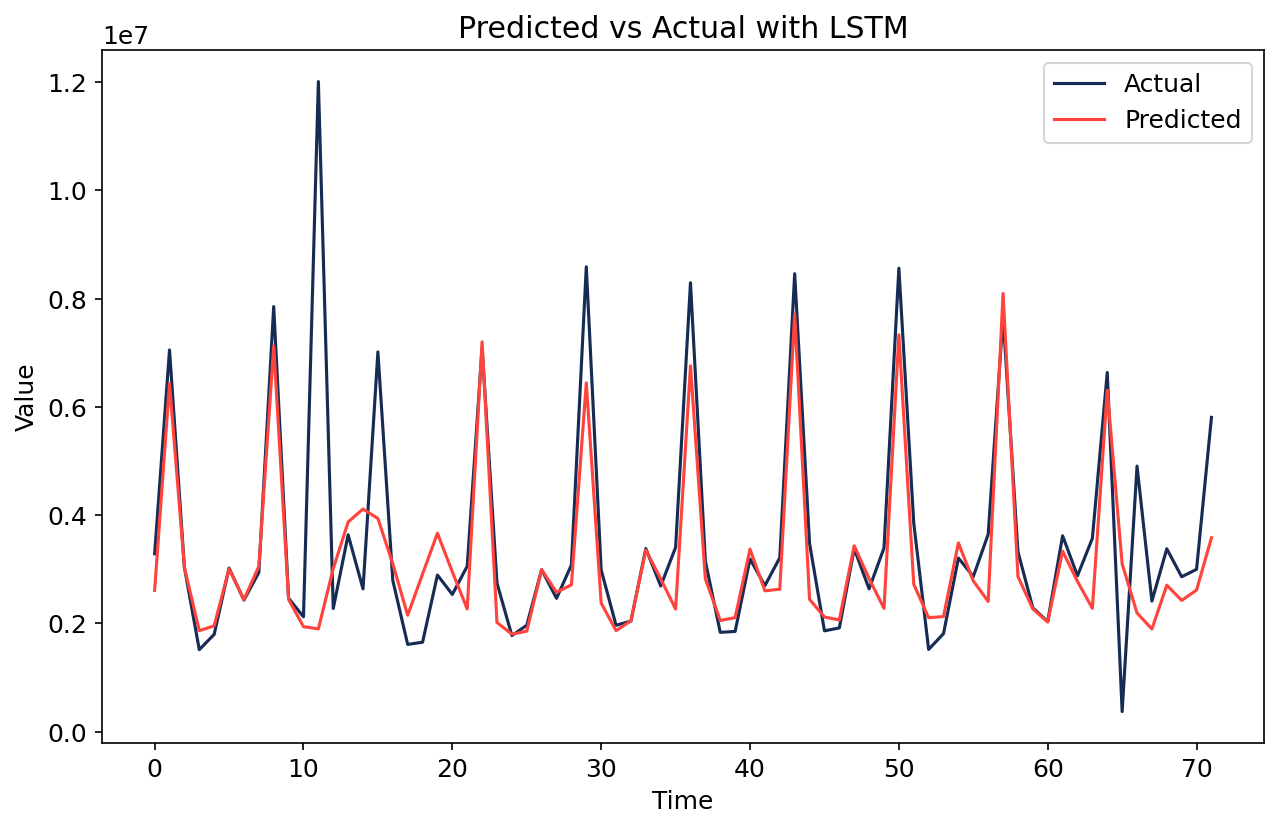

In [25]:
# Visualize LSTM
plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual', color='#162C54')
plt.plot(predictions_lstm, label='Predicted', color='#FF443D')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Predicted vs Actual with LSTM')
plt.legend()
plt.show()

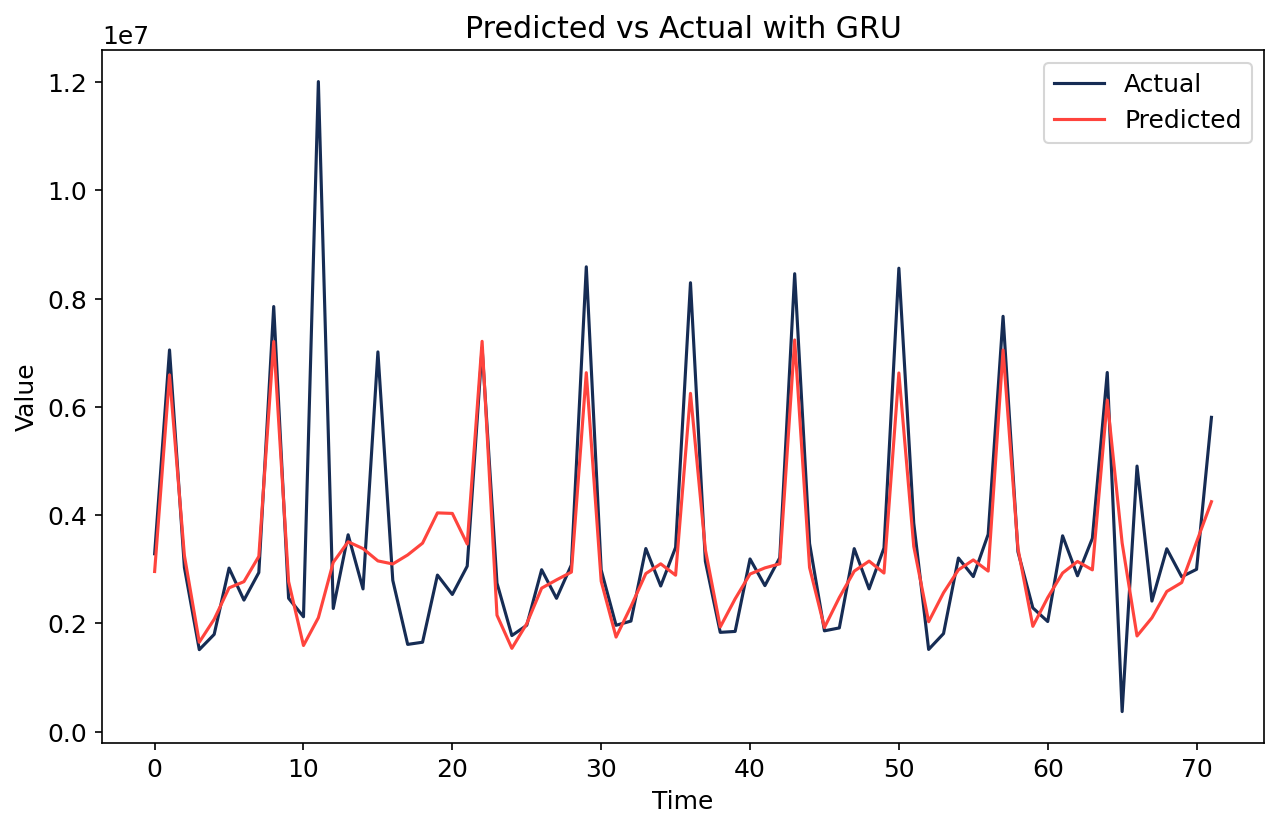

In [26]:
# Visualize gru
plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual', color='#162C54')
plt.plot(predictions_gru, label='Predicted', color='#FF443D')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Predicted vs Actual with GRU')
plt.legend()
plt.show()

In [ ]:
mae_lstm, mse_lstm, rmse_lstm, mape_lstm = calculate_metrics(predictions_lstm, actual_values)
mae_gru, mse_gru, rmse_gru, mape_gru = calculate_metrics(predictions_gru, actual_values)

In [ ]:
results.append(['LSTM', mae_lstm, mse_lstm, rmse_lstm, mape_lstm])
results.append(['GRU', mae_gru, mse_gru, rmse_gru, mape_gru])

## 3.4. Test the training and choose the best model 

In [ ]:
results

[['ARIMA',
  899947.0362078534,
  2742512947384.2866,
  1656053.425280805,
  30.910974335102342],
 ['LSTM',
  727570.2497992987,
  2225744617441.1655,
  1491892.964472038,
  26.88046181893749],
 ['GRU',
  795862.209475643,
  2343543392535.415,
  1530863.610036967,
  31.45873252476823]]

LSTM -> best model

### Save model

In [ ]:
# Save Model
with open('./models/best_lstm_model.pkl', 'wb') as f:
    pickle.dump(best_model_lstm, f)
with open('./models/best_gru_model.pkl', 'wb') as f:
    pickle.dump(best_model_gru, f)
with open('./models/best_arima_model.pkl', 'wb') as f:
    pickle.dump(arima_result, f)

# 4. Forecast total turnover with LSTM

In [ ]:
last_data = grouped_data[selected_features][-sequence_length:].values
last_data_scaled = scaler.transform(last_data)
forecast_input = last_data_scaled.reshape(1, sequence_length, len(selected_features))
forecast = []
for _ in range(90):
    prediction = best_model_lstm.predict(forecast_input)
    forecast.append(prediction[0, 0])
    forecast_input = np.roll(forecast_input, -1, axis=1)
    forecast_input[0, -1, 0] = prediction
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

1/1 [==============================] - 0s 42ms/step


In [ ]:
len(forecast)

90

In [ ]:
max_date = pd.to_datetime(grouped_data.index.max())
forecast_start_date = max_date + pd.DateOffset(days=1)
forecast_end_date = forecast_start_date + pd.Timedelta(days=89)
forecast_dates = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='D')
forecast_df = pd.DataFrame(index=forecast_dates, columns=['TOTAL_TURNOVER'])
forecast_df['TOTAL_TURNOVER'] = forecast

In [ ]:
forecast_df

,TOTAL_TURNOVER
2023-01-01,3044206.250
2023-01-02,2307482.750
2023-01-03,2293923.750
2023-01-04,2517536.500
2023-01-05,2476739.750
...,...
2023-03-27,2194244.000
2023-03-28,1698478.875
2023-03-29,1992457.125
2023-03-30,2798709.250


In [ ]:
prediction_end_date = max_date
prediction_start_date = prediction_end_date - pd.Timedelta(days=71)
prediction_dates = pd.date_range(start=prediction_start_date, end=prediction_end_date, freq='D')
prediction_df = pd.DataFrame(index=prediction_dates, columns=['TOTAL_TURNOVER'])
prediction_df['TOTAL_TURNOVER'] = predictions_lstm
prediction_df

,TOTAL_TURNOVER
2022-10-21,2.612292e+06
2022-10-22,6.433799e+06
2022-10-23,3.034068e+06
2022-10-24,1.867435e+06
2022-10-25,1.956279e+06
...,...
2022-12-27,1.897702e+06
2022-12-28,2.707068e+06
2022-12-29,2.426134e+06
2022-12-30,2.617210e+06


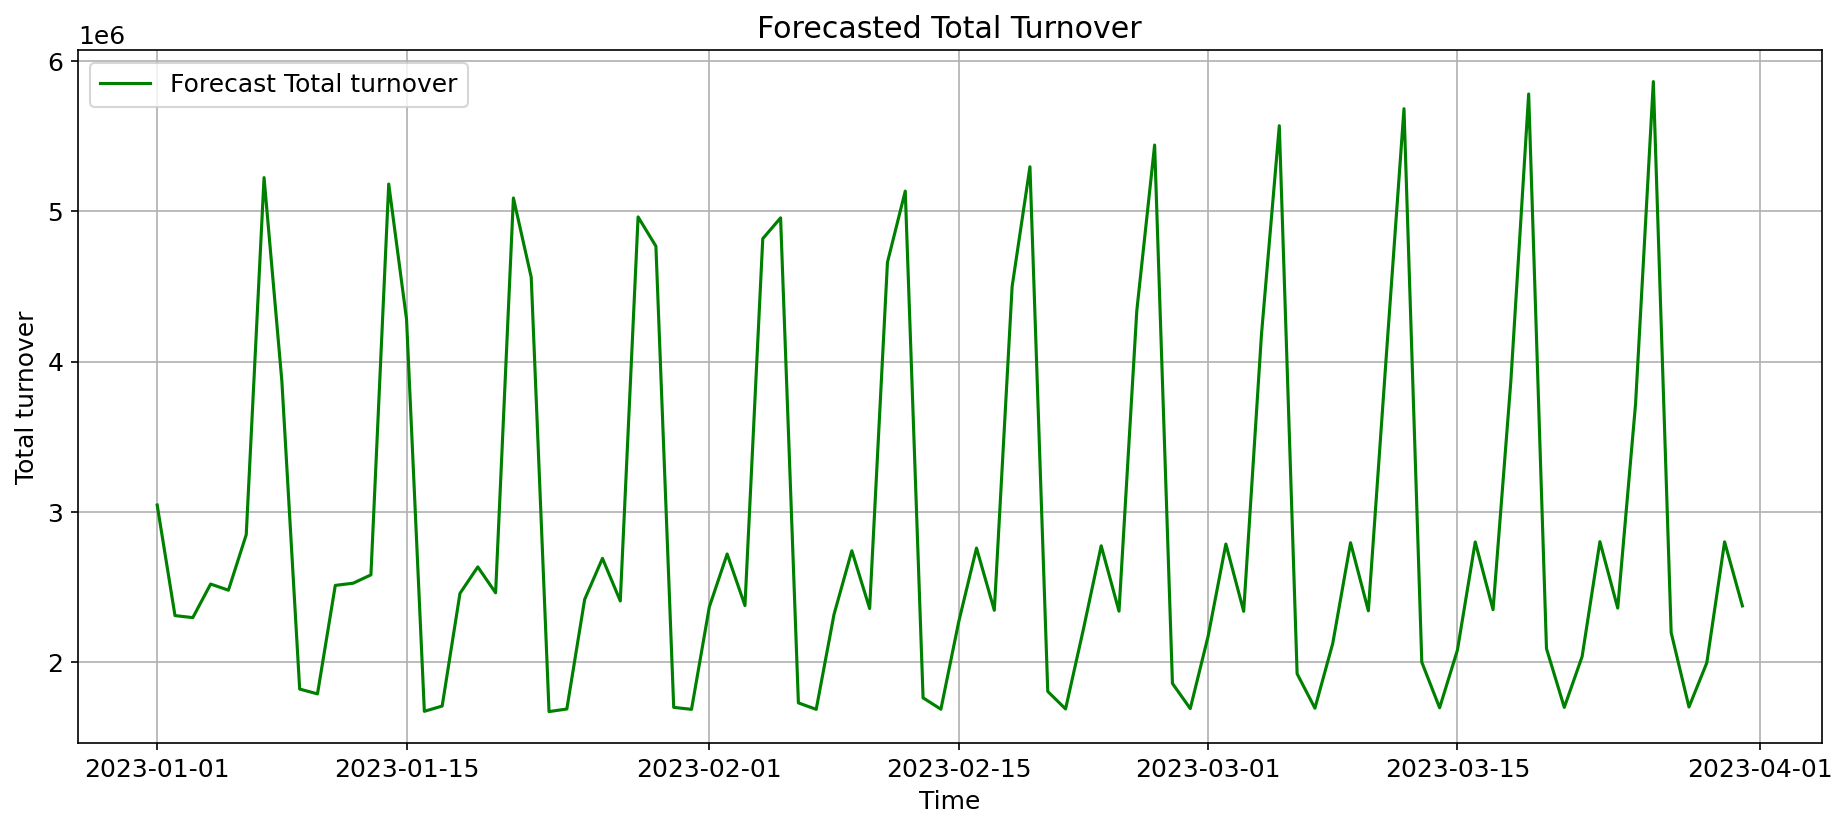

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(forecast_df.index, forecast_df['TOTAL_TURNOVER'], color='green', label='Forecast Total turnover')
plt.xlabel('Time')
plt.ylabel('Total turnover')
plt.title('Forecasted Total Turnover')
plt.legend()
plt.grid(True)
plt.show()

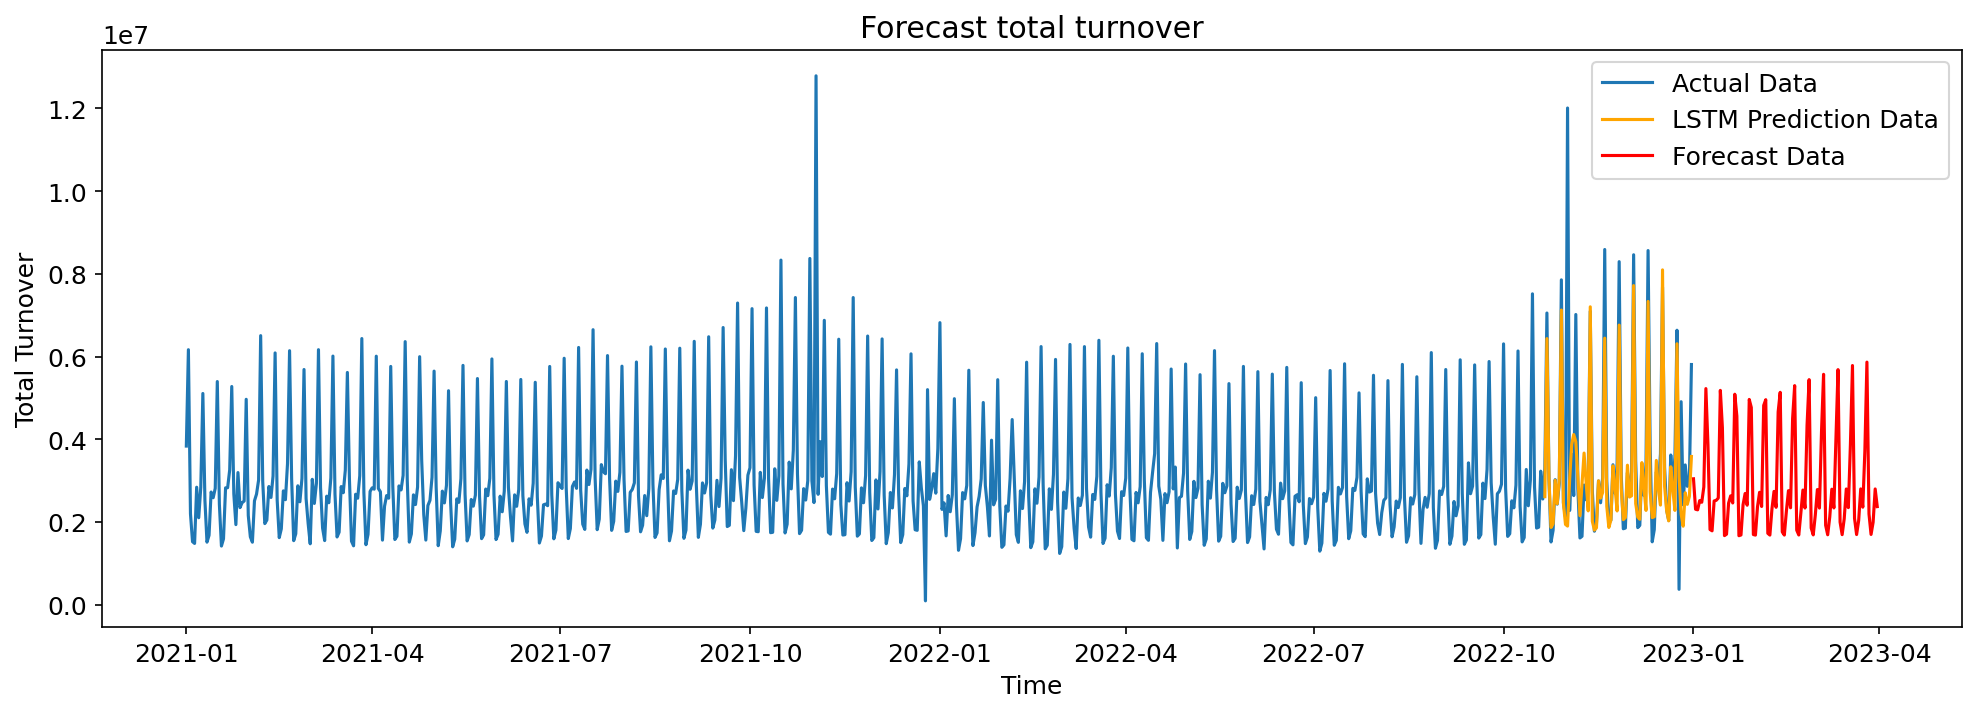

In [ ]:
grouped_data.index = pd.to_datetime(grouped_data.index)
plt.plot(grouped_data.index, grouped_data['TOTAL_TURNOVER'], label='Actual Data')
plt.plot(prediction_df.index, prediction_df['TOTAL_TURNOVER'], color='orange', label='LSTM Prediction Data')
plt.plot(forecast_df.index, forecast_df['TOTAL_TURNOVER'], color='red', label='Forecast Data')
plt.xlabel('Time')
plt.ylabel('Total Turnover')
plt.title('Forecast total turnover')
plt.legend()
plt.show()

In [ ]:
forecast_df.describe()

,TOTAL_TURNOVER
count,9.000000e+01
mean,2.913282e+06
std,1.250804e+06
min,1.667945e+06
25%,2.006185e+06
50%,2.410126e+06
75%,3.831198e+06
max,5.865324e+06


Save result forecasting

In [ ]:
forecast_df.to_csv('./data/ForecastTotalTurnover.csv')